<a href="https://colab.research.google.com/github/YaraAlnaggar/unsupervised-deep-learning_cs294-158_assignments/blob/master/gan/WGAN-GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid,save_image
import numpy as np
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
device = torch.device('cuda:0')  if torch.cuda.is_available() else  torch.device('cpu')

#### Network Definition

In [0]:
class Sum(nn.Module):
  def __init__(self):
    super(Sum,self).__init__()  
  def forward(self,x):
    return torch.sum(x,dim=2)

class LayerNorm2D(nn.Module):
  def __init__(self,modulate=False,num_features=None,condition_sz=None):
    super(LayerNorm2D,self).__init__()
    self.modulate = modulate
    if modulate:
      self.scale_layer = nn.Linear(condition_sz, num_features)
      self.bias_layer = nn.Linear(condition_sz, num_features)

  def forward(self,x,z):
    x = F.relu(F.layer_norm(x.permute(1,0,2,3),(x.shape[0],x.shape[2],x.shape[3]))).permute(1,0,2,3)
    if self.modulate:
      scale, bias = self.scale_layer(F.relu(z)), self.bias_layer(F.relu(z))
      return scale[:,:,None,None]*x + bias[:,:,None,None]
    return x

class BlockUP(nn.Module):
  def __init__(self,kernel_size, num_channels, modulate=False, condition_size=None):
    super(BlockUP,self).__init__()
    padding = kernel_size //2
    self.bn_1 = LayerNorm2D(modulate, num_channels, condition_size)
    self.conv_1 = nn.Conv2d(num_channels, num_channels, kernel_size, padding = padding)
    self.up_1 = nn.Upsample(scale_factor=2)
    self.bn_2 = LayerNorm2D(modulate,num_channels , condition_size)
    self.conv_2 = nn.Conv2d(num_channels, num_channels, kernel_size, padding = padding)

  def forward(self,x,z=None):
    x = self.bn_1(x,z)
    x = self.conv_1(x)
    x = self.bn_2(x,z)
    x = self.up_1(x)
    x = self.conv_2(x)
    return x

class ResBlockUp(nn.Module):
  def __init__(self,kernel_size, num_channels, modulate=False, condition_size=None):
    super(ResBlockUp, self).__init__()
    padding = kernel_size //2                             
    self.up_block = BlockUP(kernel_size, num_channels, modulate, condition_size)
    self.res_block = nn.Sequential(nn.Upsample(scale_factor=2),
                                   nn.Conv2d(num_channels,num_channels,1)
                                   )
  def forward(self,x,z=None):
    return  self.up_block(x,z) + self.res_block(x)


class ResBlockDown(nn.Module):
  def __init__(self,kernel_size, in_channels, out_channels):
    super(ResBlockDown, self).__init__()
    padding = kernel_size //2
    self.down_block = nn.Sequential(nn.ReLU(),
                                    nn.Conv2d(in_channels,out_channels,kernel_size,padding = padding),
                                    nn.ReLU(),
                                    nn.AvgPool2d(kernel_size = 2),
                                    nn.Conv2d(out_channels,out_channels,kernel_size,padding = padding))
    self.res_block = nn.Sequential(nn.AvgPool2d(kernel_size = 2),
                                   nn.Conv2d(in_channels,out_channels,1))
  def forward(self,x):
    return  self.down_block(x) + self.res_block(x)

class ResBlock(nn.Module):
  def __init__(self,kernel_size,in_channels, out_channels):
    super(ResBlock,self).__init__()
    padding = kernel_size //2
    self.block = nn.Sequential(nn.ReLU(),
                               nn.Conv2d(in_channels,out_channels,kernel_size,padding = padding),
                               nn.ReLU(),
                               nn.Conv2d(out_channels,out_channels,kernel_size,padding = padding)
                               )
  def forward(self,x):
    return self.block(x)+x

In [0]:
class Generator(nn.Module):
  def __init__(self,expan=2,modulate=False, condition_size=None):
    super(Generator, self).__init__()
    self.expan = expan
    self.modulate= modulate
    self.dense = nn.Linear(128,4*4*128*expan)
    self.res_1 = ResBlockUp(3, 128*expan,modulate,condition_size)
    self.res_2 = ResBlockUp(3, 128*expan,modulate,condition_size)
    self.res_3 = ResBlockUp(3, 128*expan,modulate,condition_size)
    self.bn_3 =  LayerNorm2D(modulate,128*expan,condition_size)
    self.conv = nn.Conv2d(128*expan,3,3,padding = 1)

  def forward(self, x, z = None):
    if self.modulate: z=x.clone()
    x  = self.dense(x).view((-1,128*self.expan,4,4))
    x = self.res_1(x,z)
    x = self.res_2(x,z)
    x = self.res_3(x,z)
    x = self.bn_3(x,z)
    x = F.tanh(self.conv(x))
    return x

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.model  = nn.Sequential(ResBlockDown(kernel_size = 3, in_channels = 3, out_channels = 128),
                                ResBlockDown(kernel_size = 3, in_channels = 128, out_channels = 128),
                                ResBlock(kernel_size = 3, in_channels = 128, out_channels = 128),
                                ResBlock(kernel_size = 3, in_channels = 128, out_channels = 128),
                                nn.ReLU(),
                                nn.Flatten(start_dim=2),
                                Sum(),
                                nn.Linear(128,1)
                                )
  def forward(self, x):
    return self.model(x)

#### Loss and metrics

In [0]:
def gp(in_inter,disc_model):
  out_inter = disc_model(in_inter)
  gradients = torch.autograd.grad(outputs=out_inter, inputs=in_inter,
                              grad_outputs= torch.ones(out_inter.size()).cuda() if in_inter.is_cuda else torch.ones(out_inter.size()).cpu(),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
  gradients = gradients.view(gradients.size()[0], -1)
  gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
  return ((gradients_norm - 1) ** 2).mean() 

def criterion_d(x_delta, x, x_hat,disc_model, lam):
  p1 = x_delta.mean()-x.mean() 
  p2 = lam*gp(x_hat,disc_model) 
  return p1+p2

def criterion_g(input):
  return -input.mean()

In [0]:
def get_inception_score(model,dataset_loader,classes_num=10, split_size=20):
  from math import ceil
  def preprocess(image):
    
    IMAGE_SIZE = 99
    padding = (299-IMAGE_SIZE)//2
    transform = transforms.Compose(
          [transforms.ToPILImage(),
           transforms.Resize(IMAGE_SIZE),
           transforms.Pad(padding),
           transforms.ToTensor(),
           transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
    return transform(image)

  eps = 1e-6
  model.eval()
  preds = torch.zeros((len(dataset_loader)),classes_num)
  for i,data in enumerate(dataset_loader):
    pred = model.to(device)(preprocess(data).unsqueeze(dim=0).to(device))
    preds[i*len(pred):(i+1)*len(pred)] = F.softmax(pred, dim=1)

  splits_num = ceil(len(dataset_loader)/split_size)
  splits_scores = []
  for i in range(splits_num):
    end = (i+1)*split_size
    if i==splits_num-1: end=len(preds)
    p_y = torch.mean(preds[i*split_size:end], dim=0, keepdim=True) 
    score_per_img =  torch.sum(preds[i*split_size:end]*(torch.log(preds[i*split_size:end]+eps) - torch.log(p_y+eps)), dim=1, keepdim=True) # return tensor of shape (N,1)    inception_score = torch.exp(torch.mean(score_per_imgs)).item()
    inception_score = torch.exp(torch.mean(score_per_img)).item()
    splits_scores.append(inception_score)
  return np.mean(splits_scores), np.std(splits_scores)

#### Dataloader

In [7]:
import torchvision
IMAGE_SIZE = 32
transform = transforms.Compose(
    [transforms.Resize(IMAGE_SIZE),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

# Load dataset
cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
cifar_val = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
#loadind inception model weights
inception_model = torchvision.models.inception.inception_v3(pretrained=False, transform_input=False, progress=True, num_classes=10,aux_logits=False).to(device)
checkpoint = torch.load("/content/drive/My Drive/inception_cifar10.tar",map_location=torch.device(device))
inception_model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

**Training setup**<br>
With the architecture clear and following optimization hyperparameters Adam parameters:<br>
α = 2e−4; β1 = 0; β2 = 0:9, λ = 10, ncritic = 5, LR (α) decayed to 0 over 100K iterations, implement the following variations of WGAN-GP [2] on CIFAR

**Deliverables**<br>
You are expected to report the following for the above models trained for 50K (or more)
iterations:<br>
• 100 samples<br>
• Inception Score (https://github.com/openai/improved-gan/tree/master/inception_score)
but with an Inception Architecture Classifier trained from scratch on CIFAR-10. Use the
same classifier for all the models.<br>
• (Optional / Bonus): Freschet Inception Distance of the final models (with mean and standard
deviation of your estimates)



#### Task 1
WGAN-GP, batch size=128. The LR should be decayed to 0 over 100K iterations.

In [0]:
step_num = 50000
batch_size = 128
epoch_steps = len(cifar_train) // batch_size
epoch_num = (step_num) // epoch_steps
lam = 10
n_critic = 5
epoch_num

128

In [0]:
model_g = Generator().to(device)
model_d = Discriminator().to(device)
optim_g = torch.optim.Adam(model_g.parameters(),lr=2e-4, betas=(0,0.9))
optim_d = torch.optim.Adam(model_d.parameters(),lr=2e-4, betas=(0,0.9))
scheduler_d = torch.optim.lr_scheduler.CosineAnnealingLR(optim_d, step_num)
scheduler_g = torch.optim.lr_scheduler.CosineAnnealingLR(optim_g, step_num)

train_loader = DataLoader(cifar_train, batch_size =batch_size,shuffle = True)
val_loader = DataLoader(cifar_val, batch_size =batch_size,shuffle = False)

In [0]:
# ## restore model
# checkpoint = torch.load("/content/drive/My Drive/task_a_gan_discriminator.tar",map_location=torch.device(device))
# model_d.load_state_dict(checkpoint["model"])
# loss_d_arr = checkpoint["loss"]
# optim_d.load_state_dict(checkpoint["optimizer"])
# checkpoint = torch.load("/content/drive/My Drive/task_a_gan_generator.tar",map_location=torch.device(device))
# model_g.load_state_dict(checkpoint["model"])
# optim_g.load_state_dict(checkpoint["optimizer"])
# loss_g_arr = checkpoint["loss"]

In [0]:
loss_d_arr, loss_g_arr = [], []
for epoch in tqdm(range(0,epoch_num), total = epoch_num, desc="Epochs"):
  loss_d_epoch, loss_g_epoch = 0, 0
  for step, (x_real,_) in tqdm(enumerate(train_loader),total=len(train_loader), desc="Batches"):
    x_real = x_real.to(device)
    optim_d.zero_grad()
    z = torch.normal(mean=0, std=1.0, size = (x_real.size()[0],128)).to(device)
    eps = torch.rand(x_real.size()[0]).view(-1,1,1,1).to(device)
    x_fake = model_g(z).detach()
    x_fake.requires_grad_()
    x_real.requires_grad_()
    x_interpolate = (eps*x_real)+ ((1-eps)*x_fake)
    loss_d = model_d(x_fake).mean() - model_d(x_real).mean() + (lam * gp(x_interpolate, model_d))
    loss_d_epoch += loss_d.item()
    loss_d.backward()
    optim_d.step()

    if (step+1)%n_critic == 0:
      optim_g.zero_grad()
      z = torch.normal(mean=0, std=1.0, size = (x_real.size()[0],128)).to(device)
      loss_g = criterion_g(model_d(model_g(z)))
      loss_g_epoch += loss_g.item()
      loss_g.backward()
      optim_g.step()
    if step%100==0:
      tqdm.write("Step Disriminator loss {} \n\tGenerator loss {} ".format(loss_d, loss_g) )
    scheduler_g.step()
    scheduler_d.step()
  tqdm.write("Epoch {}\tDisriminator loss {} \n\tGenerator loss {} ".format(epoch,loss_d_epoch/step, loss_g_epoch/(step//5) ))
  loss_d_arr.append(loss_d_epoch/step)
  loss_g_arr.append(loss_g_epoch/step)

  # z = torch.normal(mean=0, std=1.0, size = (30,128)).to(device)
  # save_image(model_g(z),"/content/drive/My Drive/gifs/epoch_{}.jpg".format(epoch),normalize = True)
  # model_save_name = 'task_a_gan_generator.tar' 
  # path = F"/content/drive/My Drive/{model_save_name}"
  # state_dict = {"model": model_g.state_dict(), "optimizer": optim_g.state_dict(), "loss":loss_g_arr}
  # torch.save(state_dict, path)
  # print("generator saved successfuly") 
  # model_save_name = 'task_a_gan_discriminator.tar' 
  # path = F"/content/drive/My Drive/{model_save_name}"
  # state_dict = {"model": model_d.state_dict(), "optimizer": optim_d.state_dict(), "loss":loss_d_arr}
  # torch.save(state_dict, path)
  # print("discriminator saved successfuly") 


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Step Disriminator loss 6.073101997375488 
	Generator loss 0 


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Step Disriminator loss 1.3823444843292236 
	Generator loss -20.34618377685547 
Step Disriminator loss -2.591958522796631 
	Generator loss 38.23427200317383 
Step Disriminator loss 3.1937332153320312 
	Generator loss 55.29173278808594 

Epoch 0	Disriminator loss -5.313236394486366 
	Generator loss 19.744126385603195 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -3.662445545196533 
	Generator loss 60.03942108154297 
Step Disriminator loss 1.4529651403427124 
	Generator loss 63.7132682800293 
Step Disriminator loss 5.468770503997803 
	Generator loss 61.636837005615234 
Step Disriminator loss 5.743495941162109 
	Generator loss 5.712492942810059 

Epoch 1	Disriminator loss -2.9445396507397676 
	Generator loss -0.4908174008895189 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -2.336888313293457 
	Generator loss -44.98915100097656 
Step Disriminator loss -0.29193350672721863 
	Generator loss 19.807889938354492 
Step Disriminator loss 4.056681156158447 
	Generator loss -3.027157783508301 
Step Disriminator loss 0.998684287071228 
	Generator loss 17.315711975097656 

Epoch 2	Disriminator loss -2.287211736310751 
	Generator loss 11.080169798280949 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.6281942129135132 
	Generator loss 5.0814208984375 
Step Disriminator loss 1.5265557765960693 
	Generator loss 23.145301818847656 
Step Disriminator loss 1.803566813468933 
	Generator loss -10.639957427978516 
Step Disriminator loss 2.011491060256958 
	Generator loss 42.56068420410156 

Epoch 3	Disriminator loss -1.9207521736430817 
	Generator loss -0.38375446553795767 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.1352829933166504 
	Generator loss -0.9606855511665344 
Step Disriminator loss 2.1968369483947754 
	Generator loss 9.707507133483887 
Step Disriminator loss 6.029286861419678 
	Generator loss 6.140879154205322 
Step Disriminator loss 4.603242874145508 
	Generator loss 8.920662879943848 

Epoch 4	Disriminator loss -1.317895203943436 
	Generator loss -1.1830094636250765 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.3126186728477478 
	Generator loss -29.583961486816406 
Step Disriminator loss -0.26049602031707764 
	Generator loss 12.739521980285645 
Step Disriminator loss 0.5816367268562317 
	Generator loss 6.690424919128418 
Step Disriminator loss 0.1054924726486206 
	Generator loss 14.431999206542969 

Epoch 5	Disriminator loss -1.0940459588972422 
	Generator loss -1.1142008583515117 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss 0.1830958127975464 
	Generator loss 0.9115341305732727 
Step Disriminator loss 2.616664171218872 
	Generator loss 1.1404601335525513 
Step Disriminator loss 0.9896599054336548 
	Generator loss 6.904295921325684 
Step Disriminator loss 2.3063511848449707 
	Generator loss -20.097558975219727 

Epoch 6	Disriminator loss -1.294203633757738 
	Generator loss -0.4467681669271909 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.0933773517608643 
	Generator loss 11.77299690246582 
Step Disriminator loss 0.6421010494232178 
	Generator loss -18.82730484008789 
Step Disriminator loss -0.06835440546274185 
	Generator loss -11.033183097839355 
Step Disriminator loss 0.4434294104576111 
	Generator loss 4.659066200256348 

Epoch 7	Disriminator loss -1.2459320246218106 
	Generator loss 2.186693754524757 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss 0.035426586866378784 
	Generator loss 18.50057029724121 
Step Disriminator loss -0.16772113740444183 
	Generator loss 0.9347357153892517 
Step Disriminator loss 2.105757236480713 
	Generator loss -6.651164531707764 
Step Disriminator loss -0.25902289152145386 
	Generator loss 8.255216598510742 

Epoch 8	Disriminator loss -1.2245299392976823 
	Generator loss 0.821604630503899 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8963757157325745 
	Generator loss -12.067583084106445 
Step Disriminator loss 3.2282233238220215 
	Generator loss -13.380876541137695 
Step Disriminator loss 0.7499285340309143 
	Generator loss 12.284590721130371 
Step Disriminator loss 0.4716460704803467 
	Generator loss -4.140995502471924 

Epoch 9	Disriminator loss -1.163963871372816 
	Generator loss -0.7140595828875517 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.10515624284744263 
	Generator loss -1.590486764907837 
Step Disriminator loss 1.4747899770736694 
	Generator loss -12.561149597167969 
Step Disriminator loss 2.531691074371338 
	Generator loss -6.717938423156738 
Step Disriminator loss -0.3454962372779846 
	Generator loss -4.000433921813965 

Epoch 10	Disriminator loss -1.17274173108431 
	Generator loss -1.596899083027473 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8339716196060181 
	Generator loss 18.122596740722656 
Step Disriminator loss 0.06274393200874329 
	Generator loss 1.9317632913589478 
Step Disriminator loss 0.17141300439834595 
	Generator loss -8.576732635498047 
Step Disriminator loss 0.36155128479003906 
	Generator loss 8.435493469238281 

Epoch 11	Disriminator loss -1.1349366719715106 
	Generator loss -1.8022540303377004 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss 0.2218533754348755 
	Generator loss -9.047012329101562 
Step Disriminator loss -0.43522197008132935 
	Generator loss -1.2039430141448975 
Step Disriminator loss 2.528376817703247 
	Generator loss -7.027284622192383 
Step Disriminator loss 0.11671870946884155 
	Generator loss -9.082220077514648 

Epoch 12	Disriminator loss -1.1489672564161129 
	Generator loss -2.352592940131823 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7585551142692566 
	Generator loss -6.712590217590332 
Step Disriminator loss 0.38110026717185974 
	Generator loss -8.089017868041992 
Step Disriminator loss 0.131300687789917 
	Generator loss -4.411125659942627 
Step Disriminator loss -0.24890758097171783 
	Generator loss 4.139803409576416 

Epoch 13	Disriminator loss -1.1077636807010725 
	Generator loss -1.8007941847332778 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.4961920976638794 
	Generator loss 0.31257298588752747 
Step Disriminator loss 0.8821811676025391 
	Generator loss -7.907956123352051 
Step Disriminator loss 0.1511782705783844 
	Generator loss 2.1724252700805664 
Step Disriminator loss -0.307235985994339 
	Generator loss 3.342588186264038 

Epoch 14	Disriminator loss -1.085563280719977 
	Generator loss -1.9217064111278608 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7685166597366333 
	Generator loss -11.09044075012207 
Step Disriminator loss 0.5680596232414246 
	Generator loss 2.033632755279541 
Step Disriminator loss -0.6011479496955872 
	Generator loss -2.37982439994812 
Step Disriminator loss 1.2554126977920532 
	Generator loss -16.196802139282227 

Epoch 15	Disriminator loss -1.0547775377447788 
	Generator loss -1.8314468020047896 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.07980185747146606 
	Generator loss -22.298891067504883 
Step Disriminator loss 1.3590928316116333 
	Generator loss 14.473451614379883 
Step Disriminator loss 0.8672286868095398 
	Generator loss 0.7572956085205078 
Step Disriminator loss 0.5541561841964722 
	Generator loss -17.738605499267578 

Epoch 16	Disriminator loss -1.0356562073318623 
	Generator loss -1.256271323714501 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7151796817779541 
	Generator loss 10.040107727050781 
Step Disriminator loss -0.23785659670829773 
	Generator loss 7.809861183166504 
Step Disriminator loss 1.0851023197174072 
	Generator loss -5.20173454284668 
Step Disriminator loss 0.5365580320358276 
	Generator loss 8.704446792602539 

Epoch 17	Disriminator loss -1.018716740455383 
	Generator loss -1.5439322219254115 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.0944461822509766 
	Generator loss -1.248520016670227 
Step Disriminator loss -0.7439302206039429 
	Generator loss 14.361413955688477 
Step Disriminator loss -0.2989274263381958 
	Generator loss 2.143831729888916 
Step Disriminator loss 0.3892631530761719 
	Generator loss -14.735054016113281 

Epoch 18	Disriminator loss -1.0048245852001203 
	Generator loss -2.2146471447478504 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7806218266487122 
	Generator loss -17.411272048950195 
Step Disriminator loss 0.31717735528945923 
	Generator loss -8.583391189575195 
Step Disriminator loss -0.6425244808197021 
	Generator loss -7.507557392120361 
Step Disriminator loss -0.07210206985473633 
	Generator loss -2.116288423538208 

Epoch 19	Disriminator loss -0.9374862668510431 
	Generator loss -1.0672761923991716 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7630237340927124 
	Generator loss -18.36737060546875 
Step Disriminator loss 1.2476110458374023 
	Generator loss -16.091854095458984 
Step Disriminator loss -0.3833850920200348 
	Generator loss -4.863249778747559 
Step Disriminator loss 0.42046791315078735 
	Generator loss -7.216442108154297 

Epoch 20	Disriminator loss -0.9111387310692898 
	Generator loss -2.402230706113653 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.3382962942123413 
	Generator loss 16.394256591796875 
Step Disriminator loss 0.21601556241512299 
	Generator loss 6.066046237945557 
Step Disriminator loss 0.9188395738601685 
	Generator loss 0.5535274744033813 
Step Disriminator loss -0.3944193720817566 
	Generator loss -0.17088381946086884 

Epoch 21	Disriminator loss -0.8512776905527482 
	Generator loss 0.017628157750154153 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8127659559249878 
	Generator loss -11.002145767211914 
Step Disriminator loss 0.004940792918205261 
	Generator loss -0.6791218519210815 
Step Disriminator loss -0.18117119371891022 
	Generator loss 13.447603225708008 
Step Disriminator loss 1.0039173364639282 
	Generator loss 0.8326873779296875 

Epoch 22	Disriminator loss -0.8345209404444083 
	Generator loss 0.024300627601452362 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6869504451751709 
	Generator loss 0.5808314085006714 
Step Disriminator loss 0.8293803930282593 
	Generator loss -7.088740825653076 
Step Disriminator loss 0.5587342977523804 
	Generator loss 0.6148502826690674 
Step Disriminator loss 0.8070465922355652 
	Generator loss 3.762626886367798 

Epoch 23	Disriminator loss -0.7931593279043834 
	Generator loss -0.24475121440795752 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.1792408525943756 
	Generator loss -14.295166969299316 
Step Disriminator loss -0.2639490067958832 
	Generator loss -1.135530710220337 
Step Disriminator loss -0.292776495218277 
	Generator loss -9.164092063903809 
Step Disriminator loss -0.6594640016555786 
	Generator loss 3.7087254524230957 

Epoch 24	Disriminator loss -0.767233892549307 
	Generator loss -0.8503630952670788 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.17613834142684937 
	Generator loss -14.85490894317627 
Step Disriminator loss 0.8575802445411682 
	Generator loss -10.124245643615723 
Step Disriminator loss -0.44890251755714417 
	Generator loss -14.078241348266602 
Step Disriminator loss -0.0033528953790664673 
	Generator loss -0.16038285195827484 

Epoch 25	Disriminator loss -0.747146170385755 
	Generator loss -1.4141956395827806 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.2853386104106903 
	Generator loss 15.036211013793945 
Step Disriminator loss 0.7994943857192993 
	Generator loss 16.37436294555664 
Step Disriminator loss 0.21931415796279907 
	Generator loss 11.907572746276855 
Step Disriminator loss -0.4136371910572052 
	Generator loss 2.4177627563476562 

Epoch 26	Disriminator loss -0.7206953052240305 
	Generator loss -1.6997752004326918 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7781840562820435 
	Generator loss -0.8979339599609375 
Step Disriminator loss -0.18494924902915955 
	Generator loss -1.2840020656585693 
Step Disriminator loss -0.533979058265686 
	Generator loss -6.122894763946533 
Step Disriminator loss 1.4505418539047241 
	Generator loss 20.859792709350586 

Epoch 27	Disriminator loss -0.733391100091812 
	Generator loss -1.6633145471987052 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8084051012992859 
	Generator loss 10.034923553466797 
Step Disriminator loss 0.208382248878479 
	Generator loss 5.42152738571167 
Step Disriminator loss -0.3556538224220276 
	Generator loss -6.419264316558838 
Step Disriminator loss 0.016798458993434906 
	Generator loss 2.6352148056030273 

Epoch 28	Disriminator loss -0.7488158932863138 
	Generator loss -1.4537119888342345 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6388260126113892 
	Generator loss 0.6148786544799805 
Step Disriminator loss -0.35125836730003357 
	Generator loss 2.9527182579040527 
Step Disriminator loss -0.017140865325927734 
	Generator loss -1.9035961627960205 
Step Disriminator loss 0.03226907551288605 
	Generator loss 3.2041189670562744 

Epoch 29	Disriminator loss -0.7239812951630507 
	Generator loss -2.5775230076068487 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.47770678997039795 
	Generator loss 6.4097900390625 
Step Disriminator loss -0.46910572052001953 
	Generator loss 4.390711784362793 
Step Disriminator loss 0.13111938536167145 
	Generator loss -5.63846492767334 
Step Disriminator loss 0.033207207918167114 
	Generator loss -0.7449837923049927 

Epoch 30	Disriminator loss -0.7259941946619596 
	Generator loss -1.7682172442093873 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5031532645225525 
	Generator loss -2.5562281608581543 
Step Disriminator loss -0.6582367420196533 
	Generator loss -9.020984649658203 
Step Disriminator loss 0.14654640853405 
	Generator loss 13.551358222961426 
Step Disriminator loss -0.5276798009872437 
	Generator loss 3.7352752685546875 

Epoch 31	Disriminator loss -0.7390193456067489 
	Generator loss -1.681872920348094 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8312606811523438 
	Generator loss 5.064621448516846 
Step Disriminator loss 0.31592801213264465 
	Generator loss 1.2669382095336914 
Step Disriminator loss -0.013709038496017456 
	Generator loss 3.8545351028442383 
Step Disriminator loss 0.5214824676513672 
	Generator loss 2.173035144805908 

Epoch 32	Disriminator loss -0.7285383648883837 
	Generator loss -1.5703425193444276 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7009667754173279 
	Generator loss 9.046546936035156 
Step Disriminator loss -0.20318615436553955 
	Generator loss -2.089799404144287 
Step Disriminator loss -0.41135692596435547 
	Generator loss -12.887779235839844 
Step Disriminator loss -0.09547415375709534 
	Generator loss 3.0359296798706055 

Epoch 33	Disriminator loss -0.7087794029941925 
	Generator loss -3.082469455921688 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.592027485370636 
	Generator loss -0.029759809374809265 
Step Disriminator loss 0.018895089626312256 
	Generator loss 2.0002706050872803 
Step Disriminator loss -0.5542042851448059 
	Generator loss -2.281365394592285 
Step Disriminator loss -0.18590348958969116 
	Generator loss -3.305874824523926 

Epoch 34	Disriminator loss -0.7076006449567966 
	Generator loss -2.1227203959073777 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5179774165153503 
	Generator loss -6.762681007385254 
Step Disriminator loss -0.5927531719207764 
	Generator loss 4.255061626434326 
Step Disriminator loss -0.011656403541564941 
	Generator loss 6.707920074462891 
Step Disriminator loss -0.5843227505683899 
	Generator loss -3.795769453048706 

Epoch 35	Disriminator loss -0.6836162161846191 
	Generator loss -1.6665247415120785 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5570138692855835 
	Generator loss -5.8158369064331055 
Step Disriminator loss 0.04096245765686035 
	Generator loss 4.4261794090271 
Step Disriminator loss 0.1776925027370453 
	Generator loss 5.478275775909424 
Step Disriminator loss -0.13576805591583252 
	Generator loss -8.772821426391602 

Epoch 36	Disriminator loss -0.6921806095024714 
	Generator loss -2.4467315923136015 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.151890829205513 
	Generator loss 1.4574058055877686 
Step Disriminator loss -0.6510046124458313 
	Generator loss -7.551304340362549 
Step Disriminator loss 0.0565548837184906 
	Generator loss -6.243655204772949 
Step Disriminator loss 0.5278364419937134 
	Generator loss 5.9705047607421875 

Epoch 37	Disriminator loss -0.6945912497643477 
	Generator loss -1.497456395282195 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.41729217767715454 
	Generator loss -13.316742897033691 
Step Disriminator loss -0.4244979918003082 
	Generator loss -5.037009239196777 
Step Disriminator loss 0.711750864982605 
	Generator loss 8.736259460449219 
Step Disriminator loss 1.1881425380706787 
	Generator loss 14.764141082763672 

Epoch 38	Disriminator loss -0.6762702667846894 
	Generator loss -2.208260711186971 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.1301453411579132 
	Generator loss -1.9762599468231201 
Step Disriminator loss -0.025826483964920044 
	Generator loss -16.059123992919922 
Step Disriminator loss -0.525439977645874 
	Generator loss -7.615105152130127 
Step Disriminator loss -0.21832068264484406 
	Generator loss -7.033830642700195 

Epoch 39	Disriminator loss -0.6816800188368711 
	Generator loss -1.4831951818405054 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.22426296770572662 
	Generator loss 3.37506103515625 
Step Disriminator loss 0.005005106329917908 
	Generator loss -0.24247555434703827 
Step Disriminator loss -0.29276853799819946 
	Generator loss 9.913859367370605 
Step Disriminator loss -0.16205939650535583 
	Generator loss -1.9423530101776123 

Epoch 40	Disriminator loss -0.6483944024030979 
	Generator loss -3.1381818405710735 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8649036288261414 
	Generator loss -2.8373167514801025 
Step Disriminator loss -0.6906446814537048 
	Generator loss 1.4362956285476685 
Step Disriminator loss 0.00420539453625679 
	Generator loss -4.33803653717041 
Step Disriminator loss 0.062395356595516205 
	Generator loss -8.83411693572998 

Epoch 41	Disriminator loss -0.6426454020043214 
	Generator loss -2.062893119760049 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.17489704489707947 
	Generator loss -5.947597503662109 
Step Disriminator loss 0.5795385837554932 
	Generator loss -22.983234405517578 
Step Disriminator loss -0.3421563506126404 
	Generator loss -10.228448867797852 
Step Disriminator loss -0.42840757966041565 
	Generator loss 3.898627281188965 

Epoch 42	Disriminator loss -0.6482155558772577 
	Generator loss -1.2707692702324727 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5519062876701355 
	Generator loss 5.769104957580566 
Step Disriminator loss -0.7418128252029419 
	Generator loss -5.181734085083008 
Step Disriminator loss -0.7616164684295654 
	Generator loss -1.8394083976745605 
Step Disriminator loss -0.33948707580566406 
	Generator loss 3.7546567916870117 

Epoch 43	Disriminator loss -0.654269660799167 
	Generator loss -1.548273626046303 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8197615146636963 
	Generator loss 2.2949039936065674 
Step Disriminator loss 0.6209254264831543 
	Generator loss -15.023168563842773 
Step Disriminator loss -0.6592668294906616 
	Generator loss 0.4897294044494629 
Step Disriminator loss -0.20056411623954773 
	Generator loss 3.727749824523926 

Epoch 44	Disriminator loss -0.6315328997870286 
	Generator loss -1.3714147424086547 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7141379714012146 
	Generator loss -1.9156855344772339 
Step Disriminator loss 0.4977090656757355 
	Generator loss -6.510477066040039 
Step Disriminator loss -0.07699059695005417 
	Generator loss 2.5299365520477295 
Step Disriminator loss 0.15159034729003906 
	Generator loss -15.436574935913086 

Epoch 45	Disriminator loss -0.6362336619064594 
	Generator loss -0.4840188068457139 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6322711706161499 
	Generator loss -2.2955620288848877 
Step Disriminator loss -0.10813121497631073 
	Generator loss 5.607095241546631 
Step Disriminator loss 0.017419248819351196 
	Generator loss -12.545516967773438 
Step Disriminator loss 0.1919839233160019 
	Generator loss -1.126619577407837 

Epoch 46	Disriminator loss -0.6247243891732815 
	Generator loss -1.6975786339205046 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5310618877410889 
	Generator loss 2.3177645206451416 
Step Disriminator loss 0.2818070352077484 
	Generator loss -5.675715446472168 
Step Disriminator loss 0.4047618508338928 
	Generator loss 3.396021842956543 
Step Disriminator loss -0.3233022093772888 
	Generator loss 11.38514518737793 

Epoch 47	Disriminator loss -0.6404989276654445 
	Generator loss -1.3824090159092195 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss 0.257088303565979 
	Generator loss -2.7879347801208496 
Step Disriminator loss -0.3560715317726135 
	Generator loss -4.015460968017578 
Step Disriminator loss -0.3518332242965698 
	Generator loss -11.387886047363281 
Step Disriminator loss 0.33119091391563416 
	Generator loss 2.328129768371582 

Epoch 48	Disriminator loss -0.6216320597495024 
	Generator loss -1.4399764625689921 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.408258855342865 
	Generator loss 4.632065296173096 
Step Disriminator loss -0.6015686392784119 
	Generator loss 11.05650806427002 
Step Disriminator loss -0.3851046562194824 
	Generator loss -0.6036569476127625 
Step Disriminator loss 0.232103168964386 
	Generator loss -10.485254287719727 

Epoch 49	Disriminator loss -0.6280395041960172 
	Generator loss -1.1320220722984045 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5210578441619873 
	Generator loss -3.725177526473999 
Step Disriminator loss -0.12268595397472382 
	Generator loss -1.8471330404281616 
Step Disriminator loss 0.10284506529569626 
	Generator loss -3.2742702960968018 
Step Disriminator loss -0.28588467836380005 
	Generator loss 3.2645649909973145 

Epoch 50	Disriminator loss -0.6121792848389118 
	Generator loss -1.1983534518915873 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7181398272514343 
	Generator loss -5.56532621383667 
Step Disriminator loss -0.4015364944934845 
	Generator loss -5.845325469970703 
Step Disriminator loss 0.3237888514995575 
	Generator loss -2.3791136741638184 
Step Disriminator loss -0.29279014468193054 
	Generator loss 9.746262550354004 

Epoch 51	Disriminator loss -0.6236413500629938 
	Generator loss -1.3475153372646906 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.11788026988506317 
	Generator loss 14.235078811645508 
Step Disriminator loss -0.43440884351730347 
	Generator loss -1.5700218677520752 
Step Disriminator loss -0.13402527570724487 
	Generator loss -1.3311450481414795 
Step Disriminator loss -0.03429873287677765 
	Generator loss -6.785685062408447 

Epoch 52	Disriminator loss -0.6072078718206821 
	Generator loss -2.4760425854951906 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6718080639839172 
	Generator loss 1.3108232021331787 
Step Disriminator loss 0.27268633246421814 
	Generator loss -22.89213752746582 
Step Disriminator loss -0.7041752338409424 
	Generator loss -5.863103866577148 
Step Disriminator loss -0.018491223454475403 
	Generator loss 6.708554267883301 

Epoch 53	Disriminator loss -0.612992445904857 
	Generator loss -1.9130994437787778 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.540339469909668 
	Generator loss 2.5466904640197754 
Step Disriminator loss -0.5899189114570618 
	Generator loss -1.6531739234924316 
Step Disriminator loss -0.1793842613697052 
	Generator loss -4.043158054351807 
Step Disriminator loss -0.47182926535606384 
	Generator loss -3.6531765460968018 

Epoch 54	Disriminator loss -0.5963979857376753 
	Generator loss -2.8597046192257833 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.524427592754364 
	Generator loss 6.377301216125488 
Step Disriminator loss -0.3854210376739502 
	Generator loss -1.3384628295898438 
Step Disriminator loss -0.4180946350097656 
	Generator loss -1.2400028705596924 
Step Disriminator loss -0.29198157787323 
	Generator loss -6.388152599334717 

Epoch 55	Disriminator loss -0.6042173954156729 
	Generator loss -1.1360856351944117 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.0630934089422226 
	Generator loss 2.9303781986236572 
Step Disriminator loss -0.45322513580322266 
	Generator loss -6.626303195953369 
Step Disriminator loss -0.7913244962692261 
	Generator loss 1.9947220087051392 
Step Disriminator loss -0.23987598717212677 
	Generator loss -1.8063738346099854 

Epoch 56	Disriminator loss -0.5968551670320523 
	Generator loss -2.6758877789267363 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.4583282172679901 
	Generator loss -1.2983553409576416 
Step Disriminator loss -0.5462599396705627 
	Generator loss -2.2136003971099854 
Step Disriminator loss -0.47676530480384827 
	Generator loss 0.4891636371612549 
Step Disriminator loss 0.17665880918502808 
	Generator loss -9.056973457336426 

Epoch 57	Disriminator loss -0.6053394328993864 
	Generator loss -1.9632813838812022 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5477393865585327 
	Generator loss -7.267335891723633 
Step Disriminator loss -0.24090352654457092 
	Generator loss 3.795663595199585 
Step Disriminator loss -0.4294961392879486 
	Generator loss -4.353334426879883 
Step Disriminator loss 0.26643049716949463 
	Generator loss -8.363225936889648 

Epoch 58	Disriminator loss -0.6083915444998405 
	Generator loss -1.7022719761499991 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6078380942344666 
	Generator loss 0.3255649209022522 
Step Disriminator loss -0.22820687294006348 
	Generator loss 3.5925722122192383 
Step Disriminator loss 0.14934304356575012 
	Generator loss -2.4272618293762207 
Step Disriminator loss -0.22399477660655975 
	Generator loss -8.628616333007812 

Epoch 59	Disriminator loss -0.6041013484581923 
	Generator loss -1.2316238154203465 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.38907912373542786 
	Generator loss -13.51681137084961 
Step Disriminator loss -0.3585873246192932 
	Generator loss -3.0584211349487305 
Step Disriminator loss -0.8218003511428833 
	Generator loss -1.7242441177368164 
Step Disriminator loss -0.12466815114021301 
	Generator loss -9.306522369384766 

Epoch 60	Disriminator loss -0.6056149365332646 
	Generator loss -0.9794749857332462 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7238333225250244 
	Generator loss -3.385197162628174 
Step Disriminator loss -0.5174641609191895 
	Generator loss 5.98509407043457 
Step Disriminator loss -0.3694184422492981 
	Generator loss 2.854402542114258 
Step Disriminator loss -0.5769397616386414 
	Generator loss -1.7439149618148804 

Epoch 61	Disriminator loss -0.6089204938747944 
	Generator loss -1.9836585748081024 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7799232602119446 
	Generator loss -7.6636810302734375 
Step Disriminator loss -0.20302359759807587 
	Generator loss 12.720940589904785 
Step Disriminator loss -0.604082465171814 
	Generator loss 0.9187002778053284 
Step Disriminator loss -0.3127232789993286 
	Generator loss -4.693201541900635 

Epoch 62	Disriminator loss -0.6066277271088881 
	Generator loss -1.9628760657058313 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.29881924390792847 
	Generator loss -3.4274020195007324 
Step Disriminator loss -0.5118632316589355 
	Generator loss -4.576144218444824 
Step Disriminator loss -0.0800640732049942 
	Generator loss 11.69113540649414 
Step Disriminator loss -0.5539431571960449 
	Generator loss -12.249388694763184 

Epoch 63	Disriminator loss -0.614873463832415 
	Generator loss -2.782749451219271 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7115026712417603 
	Generator loss -7.926582336425781 
Step Disriminator loss -0.05472739040851593 
	Generator loss -2.2433600425720215 
Step Disriminator loss 0.29012319445610046 
	Generator loss -4.22274923324585 
Step Disriminator loss -0.4453858733177185 
	Generator loss 1.1339945793151855 

Epoch 64	Disriminator loss -0.6174446325367078 
	Generator loss -1.8778448718098493 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.4703434109687805 
	Generator loss -0.43134430050849915 
Step Disriminator loss -0.24423569440841675 
	Generator loss -14.550413131713867 
Step Disriminator loss -0.2852277159690857 
	Generator loss -0.40028125047683716 
Step Disriminator loss -0.2925659418106079 
	Generator loss -0.6873188018798828 

Epoch 65	Disriminator loss -0.605423960997126 
	Generator loss -1.838743170388998 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.38850486278533936 
	Generator loss -0.11316243559122086 
Step Disriminator loss -0.21679091453552246 
	Generator loss -6.655470848083496 
Step Disriminator loss -0.3144204020500183 
	Generator loss 8.671165466308594 
Step Disriminator loss -0.4735190272331238 
	Generator loss -2.2164106369018555 

Epoch 66	Disriminator loss -0.6044456725510267 
	Generator loss -2.639585816134245 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6051998734474182 
	Generator loss -3.73433256149292 
Step Disriminator loss -0.42226022481918335 
	Generator loss -2.2395005226135254 
Step Disriminator loss -0.09932564198970795 
	Generator loss 0.04309951514005661 
Step Disriminator loss -0.4376978576183319 
	Generator loss -0.4561018943786621 

Epoch 67	Disriminator loss -0.6088676896805947 
	Generator loss -2.321965521440292 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7461895942687988 
	Generator loss -5.126954078674316 
Step Disriminator loss -0.5692710876464844 
	Generator loss -2.739589214324951 
Step Disriminator loss -0.3875780403614044 
	Generator loss 3.9716663360595703 
Step Disriminator loss -0.4730871021747589 
	Generator loss -5.053060531616211 

Epoch 68	Disriminator loss -0.6119521069603089 
	Generator loss -2.4973632083871427 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.0031803846359253 
	Generator loss 0.6569551229476929 
Step Disriminator loss -0.6117467284202576 
	Generator loss -14.934985160827637 
Step Disriminator loss -0.8811999559402466 
	Generator loss -2.875856637954712 
Step Disriminator loss -0.06603355705738068 
	Generator loss 0.35490551590919495 

Epoch 69	Disriminator loss -0.627611392755539 
	Generator loss -2.4736263734789996 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.4043824076652527 
	Generator loss -7.085089683532715 
Step Disriminator loss -0.36946550011634827 
	Generator loss 8.035238265991211 
Step Disriminator loss -0.5124005079269409 
	Generator loss -1.613886833190918 
Step Disriminator loss -0.5332770347595215 
	Generator loss -1.1368948221206665 

Epoch 70	Disriminator loss -0.6137470880571084 
	Generator loss -2.8155785246919365 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.405285507440567 
	Generator loss 3.4512839317321777 
Step Disriminator loss -0.38196825981140137 
	Generator loss -1.919414758682251 
Step Disriminator loss -0.4677584767341614 
	Generator loss -15.311683654785156 
Step Disriminator loss -0.2513759732246399 
	Generator loss -4.049773216247559 

Epoch 71	Disriminator loss -0.6088812563854914 
	Generator loss -2.3403759063818517 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.4616805613040924 
	Generator loss -5.63435173034668 
Step Disriminator loss -0.5472370982170105 
	Generator loss -1.082839012145996 
Step Disriminator loss -0.1207217276096344 
	Generator loss 11.375764846801758 
Step Disriminator loss -0.273515522480011 
	Generator loss -9.674751281738281 

Epoch 72	Disriminator loss -0.6056299852255064 
	Generator loss -1.3991940375895073 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.3261115550994873 
	Generator loss -2.629615545272827 
Step Disriminator loss -0.6833444237709045 
	Generator loss 3.4702036380767822 
Step Disriminator loss -0.5358447432518005 
	Generator loss -2.4101791381835938 
Step Disriminator loss -0.41461530327796936 
	Generator loss -1.086564540863037 

Epoch 73	Disriminator loss -0.61795490648693 
	Generator loss -1.9738448245021014 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6282681226730347 
	Generator loss -0.3671116828918457 
Step Disriminator loss -0.3735143542289734 
	Generator loss -5.447760581970215 
Step Disriminator loss -0.46503105759620667 
	Generator loss -12.460369110107422 
Step Disriminator loss -0.5839404463768005 
	Generator loss -2.3704330921173096 

Epoch 74	Disriminator loss -0.6300756400498825 
	Generator loss -2.857835095280256 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6435550451278687 
	Generator loss -7.296720504760742 
Step Disriminator loss -0.4952077865600586 
	Generator loss 0.11200020462274551 
Step Disriminator loss -0.5044053196907043 
	Generator loss -1.9877465963363647 
Step Disriminator loss -0.3594304621219635 
	Generator loss -7.398797035217285 

Epoch 75	Disriminator loss -0.6123996711789798 
	Generator loss -2.413301856471942 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.4322224259376526 
	Generator loss -0.8716695308685303 
Step Disriminator loss -0.332461953163147 
	Generator loss -1.3499703407287598 
Step Disriminator loss -0.527306854724884 
	Generator loss -5.1401495933532715 
Step Disriminator loss -0.6275195479393005 
	Generator loss -6.123186111450195 

Epoch 76	Disriminator loss -0.6259251815290787 
	Generator loss -2.2964951334855495 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.36158493161201477 
	Generator loss -0.540249228477478 
Step Disriminator loss -0.4387952983379364 
	Generator loss -7.728487014770508 
Step Disriminator loss -0.9860742688179016 
	Generator loss 2.83432674407959 
Step Disriminator loss -0.7340663075447083 
	Generator loss 0.11808304488658905 

Epoch 77	Disriminator loss -0.614997465421374 
	Generator loss -2.30751997557206 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5343096256256104 
	Generator loss -4.310420513153076 
Step Disriminator loss -0.31648486852645874 
	Generator loss -2.729701280593872 
Step Disriminator loss -0.6723377704620361 
	Generator loss -3.1321191787719727 
Step Disriminator loss -0.28776460886001587 
	Generator loss -5.940985679626465 

Epoch 78	Disriminator loss -0.6201535288244486 
	Generator loss -1.947819132071275 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7495962381362915 
	Generator loss -7.648283958435059 
Step Disriminator loss -0.5350918173789978 
	Generator loss -0.7926674485206604 
Step Disriminator loss -0.6708301305770874 
	Generator loss -1.7831637859344482 
Step Disriminator loss -0.30474498867988586 
	Generator loss -1.0508977174758911 

Epoch 79	Disriminator loss -0.6298520241601345 
	Generator loss -2.371979555258384 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7224856615066528 
	Generator loss -2.6715941429138184 
Step Disriminator loss -0.5381969213485718 
	Generator loss 3.012885570526123 
Step Disriminator loss -0.690021812915802 
	Generator loss -1.9392591714859009 
Step Disriminator loss -0.5974330306053162 
	Generator loss -10.793535232543945 

Epoch 80	Disriminator loss -0.6283693863031191 
	Generator loss -2.2524477254885893 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.0822732001543045 
	Generator loss -0.29773956537246704 
Step Disriminator loss -0.37241819500923157 
	Generator loss 0.7841590642929077 
Step Disriminator loss -0.5160165429115295 
	Generator loss 6.878104209899902 
Step Disriminator loss -0.44546329975128174 
	Generator loss 1.0501521825790405 

Epoch 81	Disriminator loss -0.6203162340017465 
	Generator loss -2.3894886074539943 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8627822399139404 
	Generator loss 6.28896427154541 
Step Disriminator loss -0.5788106918334961 
	Generator loss -5.923333168029785 
Step Disriminator loss 0.005816958844661713 
	Generator loss -3.4972548484802246 
Step Disriminator loss -0.3587646782398224 
	Generator loss 3.9710888862609863 

Epoch 82	Disriminator loss -0.6306804558214468 
	Generator loss -1.5712407640157602 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5497865676879883 
	Generator loss -2.2070446014404297 
Step Disriminator loss -0.20133303105831146 
	Generator loss 1.2904345989227295 
Step Disriminator loss -0.6941688656806946 
	Generator loss -2.0297136306762695 
Step Disriminator loss -0.6942170858383179 
	Generator loss -4.689875602722168 

Epoch 83	Disriminator loss -0.6302720961471399 
	Generator loss -1.8329496200506885 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5638678669929504 
	Generator loss -3.712036371231079 
Step Disriminator loss -0.4638606309890747 
	Generator loss -5.194091796875 
Step Disriminator loss -0.3173699975013733 
	Generator loss -7.7555131912231445 
Step Disriminator loss -0.7255532741546631 
	Generator loss -0.6488951444625854 

Epoch 84	Disriminator loss -0.6169536904455759 
	Generator loss -3.447296508993858 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.49196791648864746 
	Generator loss -6.1872148513793945 
Step Disriminator loss -0.34784501791000366 
	Generator loss -0.3474639654159546 
Step Disriminator loss -0.3761134743690491 
	Generator loss -6.307144641876221 
Step Disriminator loss -0.3771103620529175 
	Generator loss 0.49870365858078003 

Epoch 85	Disriminator loss -0.6316985750236572 
	Generator loss -2.0393253181320734 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.48504728078842163 
	Generator loss -2.510410785675049 
Step Disriminator loss -0.5715272426605225 
	Generator loss 1.2701066732406616 
Step Disriminator loss -0.6455826163291931 
	Generator loss -2.6039113998413086 
Step Disriminator loss -0.5949529409408569 
	Generator loss 2.3255603313446045 

Epoch 86	Disriminator loss -0.6300025105571899 
	Generator loss -2.2495303358405065 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5808587074279785 
	Generator loss 0.7230679988861084 
Step Disriminator loss -0.11673115938901901 
	Generator loss -2.4189765453338623 
Step Disriminator loss -0.6225171089172363 
	Generator loss -4.9588775634765625 
Step Disriminator loss -0.5358483791351318 
	Generator loss -4.511104583740234 

Epoch 87	Disriminator loss -0.6342185407112806 
	Generator loss -1.5603907705308535 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5585591793060303 
	Generator loss 1.712327003479004 
Step Disriminator loss -0.5802854895591736 
	Generator loss -1.0788764953613281 
Step Disriminator loss -0.4637119174003601 
	Generator loss 6.116186141967773 
Step Disriminator loss -0.6599249839782715 
	Generator loss -2.662341356277466 

Epoch 88	Disriminator loss -0.6360748176773389 
	Generator loss -2.596665022464899 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6542733311653137 
	Generator loss -6.733852863311768 
Step Disriminator loss -0.5620980262756348 
	Generator loss -7.876147270202637 
Step Disriminator loss -0.6775230765342712 
	Generator loss 1.7868008613586426 
Step Disriminator loss -0.3074645698070526 
	Generator loss -8.458393096923828 

Epoch 89	Disriminator loss -0.6342743001687221 
	Generator loss -2.799856924666808 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5738025903701782 
	Generator loss -5.9862518310546875 
Step Disriminator loss -0.6947102546691895 
	Generator loss -1.9596593379974365 
Step Disriminator loss -0.48619410395622253 
	Generator loss -4.61398983001709 
Step Disriminator loss -0.5018362402915955 
	Generator loss -2.9043707847595215 

Epoch 90	Disriminator loss -0.6441816568374634 
	Generator loss -2.3674944969706044 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8022022247314453 
	Generator loss -1.794456124305725 
Step Disriminator loss -0.5875228643417358 
	Generator loss -2.668828010559082 
Step Disriminator loss -0.5951888561248779 
	Generator loss -6.053131103515625 
Step Disriminator loss -0.9316316246986389 
	Generator loss 2.6788103580474854 

Epoch 91	Disriminator loss -0.6413308445459757 
	Generator loss -2.4590564656716127 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5161088705062866 
	Generator loss -6.613043308258057 
Step Disriminator loss -0.6032899618148804 
	Generator loss -7.215717315673828 
Step Disriminator loss -0.7898510694503784 
	Generator loss -0.467434823513031 
Step Disriminator loss -0.8514653444290161 
	Generator loss -2.5606884956359863 

Epoch 92	Disriminator loss -0.6432130534297381 
	Generator loss -2.743277839743174 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.32146787643432617 
	Generator loss -1.6065040826797485 
Step Disriminator loss -0.7498106360435486 
	Generator loss -1.1832325458526611 
Step Disriminator loss -0.2429378628730774 
	Generator loss -0.6149141788482666 
Step Disriminator loss -0.7833071947097778 
	Generator loss -0.926480233669281 

Epoch 93	Disriminator loss -0.6419198233920794 
	Generator loss -1.949056241183709 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8431545495986938 
	Generator loss -4.862887382507324 
Step Disriminator loss -0.4632878303527832 
	Generator loss -3.4794554710388184 
Step Disriminator loss -0.7538067102432251 
	Generator loss -5.407803535461426 
Step Disriminator loss -0.33263757824897766 
	Generator loss -5.344595909118652 

Epoch 94	Disriminator loss -0.6523390705386798 
	Generator loss -3.2618796691680565 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6352593898773193 
	Generator loss -9.186575889587402 
Step Disriminator loss -0.6783209443092346 
	Generator loss -3.700564384460449 
Step Disriminator loss -0.8335679769515991 
	Generator loss 0.27849793434143066 
Step Disriminator loss -0.5634905099868774 
	Generator loss -3.6714882850646973 

Epoch 95	Disriminator loss -0.6497345303113644 
	Generator loss -3.353278195628753 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.491596519947052 
	Generator loss 2.260190963745117 
Step Disriminator loss -0.312554270029068 
	Generator loss -0.6355094313621521 
Step Disriminator loss -0.7394860982894897 
	Generator loss -2.7147912979125977 
Step Disriminator loss -0.7363256812095642 
	Generator loss -5.327878952026367 

Epoch 96	Disriminator loss -0.6515553231422718 
	Generator loss -2.530994738714817 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5546838045120239 
	Generator loss 2.8519883155822754 
Step Disriminator loss -0.4532604217529297 
	Generator loss -1.865583896636963 
Step Disriminator loss -0.5916668772697449 
	Generator loss -5.053510665893555 
Step Disriminator loss -0.3439621329307556 
	Generator loss -2.309903621673584 

Epoch 97	Disriminator loss -0.6521428168584139 
	Generator loss -2.02443404113635 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7411267161369324 
	Generator loss -5.837464332580566 
Step Disriminator loss -0.9263907074928284 
	Generator loss -7.4232282638549805 
Step Disriminator loss -0.6058509945869446 
	Generator loss -4.946617603302002 
Step Disriminator loss -0.4842546284198761 
	Generator loss -1.5466856956481934 

Epoch 98	Disriminator loss -0.6527003017373574 
	Generator loss -2.109241796991764 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8509305715560913 
	Generator loss -6.11728572845459 
Step Disriminator loss -0.35315072536468506 
	Generator loss -0.1778683364391327 
Step Disriminator loss -0.8370493650436401 
	Generator loss -5.499337673187256 
Step Disriminator loss -0.6841421127319336 
	Generator loss 0.8726608753204346 

Epoch 99	Disriminator loss -0.6495891346381261 
	Generator loss -1.6661034311430576 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7125824093818665 
	Generator loss -3.6836609840393066 
Step Disriminator loss -0.7468912601470947 
	Generator loss -1.1932862997055054 
Step Disriminator loss -0.42772340774536133 
	Generator loss -0.224174365401268 
Step Disriminator loss -0.47184517979621887 
	Generator loss -8.711544036865234 

Epoch 100	Disriminator loss -0.6654921221427429 
	Generator loss -2.621796671778728 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6807354092597961 
	Generator loss -4.866216659545898 
Step Disriminator loss -0.5289750695228577 
	Generator loss -0.4481066167354584 
Step Disriminator loss -0.563559889793396 
	Generator loss -2.729034900665283 
Step Disriminator loss -0.6685459613800049 
	Generator loss -4.580169200897217 

Epoch 101	Disriminator loss -0.6597851085357177 
	Generator loss -2.2213674388252773 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5844351053237915 
	Generator loss 1.9039429426193237 
Step Disriminator loss -0.643170177936554 
	Generator loss 1.5066146850585938 
Step Disriminator loss -0.9057998657226562 
	Generator loss -2.12642240524292 
Step Disriminator loss -0.7882429361343384 
	Generator loss 1.0465000867843628 

Epoch 102	Disriminator loss -0.6533875977190641 
	Generator loss -2.016537194737257 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8542718291282654 
	Generator loss 2.665567398071289 
Step Disriminator loss -0.459153950214386 
	Generator loss -6.501879692077637 
Step Disriminator loss -0.5845840573310852 
	Generator loss 1.9100978374481201 
Step Disriminator loss -0.45373907685279846 
	Generator loss -6.5618391036987305 

Epoch 103	Disriminator loss -0.6603493840266497 
	Generator loss -2.7207762056436295 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6645952463150024 
	Generator loss -0.4170295000076294 
Step Disriminator loss -0.6442711353302002 
	Generator loss 2.0266566276550293 
Step Disriminator loss -0.8218259215354919 
	Generator loss 0.12842395901679993 
Step Disriminator loss -0.6006483435630798 
	Generator loss -2.766354560852051 

Epoch 104	Disriminator loss -0.6679046128804867 
	Generator loss -2.2147994987093487 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5009389519691467 
	Generator loss -2.544926166534424 
Step Disriminator loss -0.6858819723129272 
	Generator loss -7.310358047485352 
Step Disriminator loss -0.8279566764831543 
	Generator loss -0.35878682136535645 
Step Disriminator loss -0.8318414092063904 
	Generator loss -4.108034133911133 

Epoch 105	Disriminator loss -0.6664917083886953 
	Generator loss -2.754087631423504 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8041431307792664 
	Generator loss -2.519566774368286 
Step Disriminator loss -0.6045076251029968 
	Generator loss -3.4471054077148438 
Step Disriminator loss -0.6385211944580078 
	Generator loss -4.1497883796691895 
Step Disriminator loss -0.615185022354126 
	Generator loss -1.9944043159484863 

Epoch 106	Disriminator loss -0.6667086433905821 
	Generator loss -2.467003282446128 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8036106824874878 
	Generator loss -2.6932806968688965 
Step Disriminator loss -0.6873118281364441 
	Generator loss -2.928560256958008 
Step Disriminator loss -0.4800904393196106 
	Generator loss 1.254982829093933 
Step Disriminator loss -0.5804260969161987 
	Generator loss -2.0642800331115723 

Epoch 107	Disriminator loss -0.6689436902220433 
	Generator loss -2.98136607137246 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8094707131385803 
	Generator loss 0.4766642451286316 
Step Disriminator loss -0.2893456518650055 
	Generator loss -2.7732744216918945 
Step Disriminator loss -0.4355428218841553 
	Generator loss -6.17121696472168 
Step Disriminator loss -0.5025702714920044 
	Generator loss -1.395578145980835 

Epoch 108	Disriminator loss -0.6756856529376446 
	Generator loss -1.6017901498155716 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8973016738891602 
	Generator loss -0.5928112268447876 
Step Disriminator loss -0.5032124519348145 
	Generator loss -3.2869203090667725 
Step Disriminator loss -0.8311315178871155 
	Generator loss -0.7186981439590454 
Step Disriminator loss -0.8119226098060608 
	Generator loss -5.320937156677246 

Epoch 109	Disriminator loss -0.675833622767375 
	Generator loss -2.312986066326117 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7237602472305298 
	Generator loss -3.2154130935668945 
Step Disriminator loss -0.758692741394043 
	Generator loss -0.4811379015445709 
Step Disriminator loss -0.8135250210762024 
	Generator loss -4.649064540863037 
Step Disriminator loss -0.5994135141372681 
	Generator loss -2.4275989532470703 

Epoch 110	Disriminator loss -0.6753432005643845 
	Generator loss -1.514299137279009 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6422136425971985 
	Generator loss -1.8739646673202515 
Step Disriminator loss -0.6055532693862915 
	Generator loss -0.7832462191581726 
Step Disriminator loss -0.7402467727661133 
	Generator loss 0.7329851984977722 
Step Disriminator loss -0.8565794229507446 
	Generator loss -3.372405767440796 

Epoch 111	Disriminator loss -0.6787541365012144 
	Generator loss -2.1555678746782436 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5897383689880371 
	Generator loss -4.89068078994751 
Step Disriminator loss -0.5636965036392212 
	Generator loss -0.15170584619045258 
Step Disriminator loss -0.6955665946006775 
	Generator loss -1.7444541454315186 
Step Disriminator loss -0.7667274475097656 
	Generator loss -2.6524808406829834 

Epoch 112	Disriminator loss -0.6762764973518176 
	Generator loss -2.262279088107439 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6446322798728943 
	Generator loss -1.0536757707595825 
Step Disriminator loss -0.7442051768302917 
	Generator loss -0.8207228779792786 
Step Disriminator loss -0.5351486206054688 
	Generator loss -2.9205963611602783 
Step Disriminator loss -0.7140969634056091 
	Generator loss -1.8760935068130493 

Epoch 113	Disriminator loss -0.6813939600418776 
	Generator loss -1.7363764367854366 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7762148380279541 
	Generator loss -1.4762156009674072 
Step Disriminator loss -0.9504076838493347 
	Generator loss -2.844899892807007 
Step Disriminator loss -0.9176855087280273 
	Generator loss -1.1836906671524048 
Step Disriminator loss -0.571463406085968 
	Generator loss -1.6863071918487549 

Epoch 114	Disriminator loss -0.6765982397091694 
	Generator loss -2.516524721414615 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6266398429870605 
	Generator loss -1.797333002090454 
Step Disriminator loss -0.6472136974334717 
	Generator loss -2.552527904510498 
Step Disriminator loss -0.5912660956382751 
	Generator loss -1.4013469219207764 
Step Disriminator loss -0.5022698044776917 
	Generator loss -4.630342960357666 

Epoch 115	Disriminator loss -0.6843606695150718 
	Generator loss -2.554140380750864 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7629600167274475 
	Generator loss -0.3715151250362396 
Step Disriminator loss -0.6666682362556458 
	Generator loss -4.742363929748535 
Step Disriminator loss -0.5333366394042969 
	Generator loss -1.8233988285064697 
Step Disriminator loss -0.6939569115638733 
	Generator loss -2.126173973083496 

Epoch 116	Disriminator loss -0.6861842578038191 
	Generator loss -1.9003172360169582 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.5904515385627747 
	Generator loss -0.47327250242233276 
Step Disriminator loss -0.6103216409683228 
	Generator loss -1.9059765338897705 
Step Disriminator loss -0.6374973058700562 
	Generator loss -2.286942720413208 
Step Disriminator loss -0.38747814297676086 
	Generator loss -2.7194862365722656 

Epoch 117	Disriminator loss -0.6852022940531756 
	Generator loss -1.9268831211882524 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8975900411605835 
	Generator loss -1.8483589887619019 
Step Disriminator loss -0.7567355632781982 
	Generator loss -0.09613335132598877 
Step Disriminator loss -0.8800366520881653 
	Generator loss -3.435711145401001 
Step Disriminator loss -0.697906494140625 
	Generator loss -2.4886913299560547 

Epoch 118	Disriminator loss -0.6865473468334247 
	Generator loss -1.9149326179654171 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7906573414802551 
	Generator loss -1.7069984674453735 
Step Disriminator loss -0.5235469937324524 
	Generator loss -2.5021708011627197 
Step Disriminator loss -0.750522792339325 
	Generator loss -1.6848399639129639 
Step Disriminator loss -0.6832544207572937 
	Generator loss -2.0629591941833496 

Epoch 119	Disriminator loss -0.6896074722210567 
	Generator loss -1.8074651620326898 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.729877233505249 
	Generator loss -1.1456471681594849 
Step Disriminator loss -0.6293348073959351 
	Generator loss -2.314647912979126 
Step Disriminator loss -0.6332775354385376 
	Generator loss -2.725513458251953 
Step Disriminator loss -0.7365039587020874 
	Generator loss -1.8300855159759521 

Epoch 120	Disriminator loss -0.6915439841838983 
	Generator loss -2.149902702906193 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.4008805751800537 
	Generator loss -1.473294973373413 
Step Disriminator loss -0.5719807744026184 
	Generator loss -1.8705809116363525 
Step Disriminator loss -0.8269662857055664 
	Generator loss -2.052921772003174 
Step Disriminator loss -0.6107566356658936 
	Generator loss -2.0057501792907715 

Epoch 121	Disriminator loss -0.6864581100451641 
	Generator loss -1.750334036655915 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8034070730209351 
	Generator loss -1.750805139541626 
Step Disriminator loss -0.6609972715377808 
	Generator loss -1.9747533798217773 
Step Disriminator loss -0.7718939781188965 
	Generator loss -2.0980989933013916 
Step Disriminator loss -0.8093385696411133 
	Generator loss -2.070983648300171 

Epoch 122	Disriminator loss -0.7000126205193691 
	Generator loss -1.931557290064983 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6881889700889587 
	Generator loss -2.1800763607025146 
Step Disriminator loss -0.7488855123519897 
	Generator loss -2.534898281097412 
Step Disriminator loss -0.688003420829773 
	Generator loss -2.4089322090148926 
Step Disriminator loss -0.7134954333305359 
	Generator loss -2.5478758811950684 

Epoch 123	Disriminator loss -0.6995017836491267 
	Generator loss -2.4221501594934707 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6070151925086975 
	Generator loss -2.272864580154419 
Step Disriminator loss -0.6327579021453857 
	Generator loss -2.5373148918151855 
Step Disriminator loss -0.7193431854248047 
	Generator loss -2.2813034057617188 
Step Disriminator loss -0.7434377670288086 
	Generator loss -2.2948601245880127 

Epoch 124	Disriminator loss -0.694261978375606 
	Generator loss -2.338717362819574 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7906051278114319 
	Generator loss -2.1572229862213135 
Step Disriminator loss -0.7612940073013306 
	Generator loss -2.254117965698242 
Step Disriminator loss -0.7821456789970398 
	Generator loss -2.2815942764282227 
Step Disriminator loss -0.5805891752243042 
	Generator loss -2.2604150772094727 

Epoch 125	Disriminator loss -0.6956080869986461 
	Generator loss -2.2504016619462233 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8905091285705566 
	Generator loss -2.350001811981201 
Step Disriminator loss -0.5773471593856812 
	Generator loss -2.3303565979003906 
Step Disriminator loss -0.7726179957389832 
	Generator loss -2.310755729675293 
Step Disriminator loss -0.6173831224441528 
	Generator loss -2.2062394618988037 

Epoch 126	Disriminator loss -0.6995236056737411 
	Generator loss -2.306742909627083 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7378315925598145 
	Generator loss -2.374281883239746 
Step Disriminator loss -0.5639172196388245 
	Generator loss -2.385199785232544 
Step Disriminator loss -0.6947228312492371 
	Generator loss -2.2851972579956055 
Step Disriminator loss -0.6612675189971924 
	Generator loss -2.2470922470092773 

Epoch 127	Disriminator loss -0.6971356031986383 
	Generator loss -2.3246932518787875 
generator saved successfuly
discriminator saved successfuly



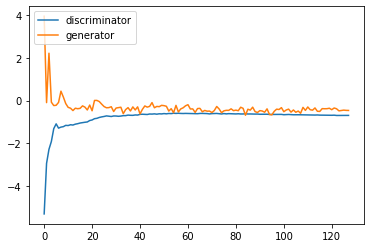

In [0]:
plt.plot(loss_d_arr,label='discriminator')
plt.legend(loc='upper left')
plt.plot(loss_g_arr,label='generator')
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Generated samples inception score: mean 3.3352859020233154 and std 0.0


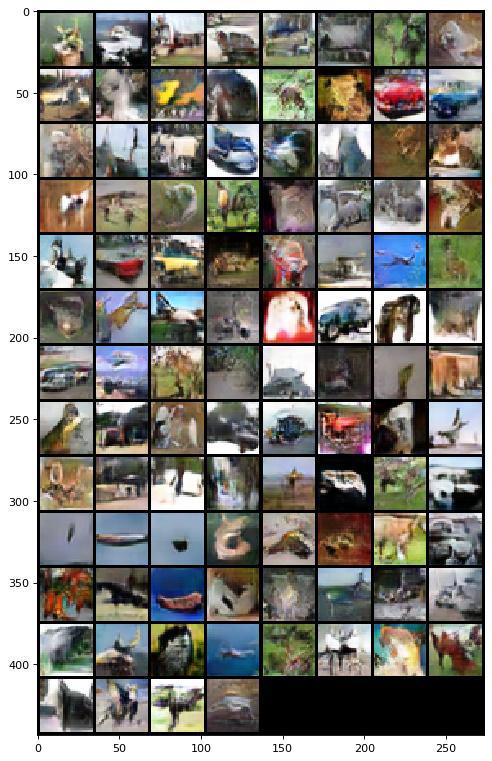

In [0]:
z_samples = torch.normal(mean=0, std=1.0, size = (100,128)).to(device)
samples = model_g.to(device)(z_samples.to(device))
inception_score = get_inception_score(inception_model.to(device),samples.detach(),split_size=100)
print("Generated samples inception score: mean {} and std {}".format(inception_score[0], inception_score[1]))
im = make_grid(samples,normalize=True)
fig=plt.figure(figsize=(14, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(np.transpose(im.cpu().detach().numpy(), (1,2,0)), interpolation='nearest')
plt.show()

#### Task 2
WGAN-GP, with ResBlocks in generator using 128 filters instead of 256 filters but trained with a larger batch size 256 instead of 128.

In [11]:
step_num = 50000
batch_size = 256
epoch_steps = len(cifar_train) // batch_size
epoch_num = (step_num) // epoch_steps
lam = 10
n_critic = 5
epoch_num

256

In [0]:
model_g = Generator(expan=1).to(device)
model_d = Discriminator().to(device)
optim_g = torch.optim.Adam(model_g.parameters(),lr=2e-4, betas=(0,0.9))
optim_d = torch.optim.Adam(model_d.parameters(),lr=2e-4, betas=(0,0.9))
scheduler_d = torch.optim.lr_scheduler.CosineAnnealingLR(optim_d, step_num)
scheduler_g = torch.optim.lr_scheduler.CosineAnnealingLR(optim_g, step_num)

train_loader = DataLoader(cifar_train, batch_size =batch_size,shuffle = True)
val_loader = DataLoader(cifar_val, batch_size =batch_size,shuffle = False)

In [0]:
# # restore model
# checkpoint = torch.load("/content/drive/My Drive/task_a_gan_discriminator_2.tar",map_location=torch.device(device))
# model_d.load_state_dict(checkpoint["model"])
# optim_d.load_state_dict(checkpoint["optimizer"])
# loss_d_arr = checkpoint["loss"]
# checkpoint = torch.load("/content/drive/My Drive/task_a_gan_generator_2.tar",map_location=torch.device(device))
# model_g.load_state_dict(checkpoint["model"])
# optim_g.load_state_dict(checkpoint["optimizer"])
# loss_g_arr = checkpoint["loss"]

In [0]:
loss_d_arr, loss_g_arr = [], []
for epoch in tqdm(range(0,epoch_num), total = epoch_num, desc="Epochs"):
  loss_d_epoch, loss_g_epoch = 0, 0
  for step, (x_real,_) in tqdm(enumerate(train_loader),total=len(train_loader), desc="Batches"):
    x_real = x_real.to(device)
    optim_d.zero_grad()
    z = torch.normal(mean=0, std=1.0, size = (x_real.size()[0],128)).to(device)
    eps = torch.rand(x_real.size()[0]).view(-1,1,1,1).to(device)
    x_fake = model_g(z).detach()
    x_fake.requires_grad_()
    x_real.requires_grad_()
    x_interpolate = (eps*x_real)+ ((1-eps)*x_fake)
    loss_d = model_d(x_fake).mean() - model_d(x_real).mean() + (lam * gp(x_interpolate, model_d))
    loss_d_epoch += loss_d.item()
    loss_d.backward()
    optim_d.step()
    if (step+1)%n_critic == 0:
      optim_g.zero_grad()
      z = torch.normal(mean=0, std=1.0, size = (x_real.size()[0],128)).to(device)
      loss_g = criterion_g(model_d(model_g(z)))
      loss_g_epoch += loss_g.item()
      loss_g.backward()
      optim_g.step()
    if step%100==0:
      tqdm.write("Step Disriminator loss {} \n\tGenerator loss {} ".format(loss_d, loss_g) )
    scheduler_g.step()
    scheduler_d.step()
  tqdm.write("Epoch {}\tDisriminator loss {} \n\tGenerator loss {} ".format(epoch,loss_d_epoch/step, loss_g_epoch/(step//5) ))
  loss_d_arr.append(loss_d_epoch/step)
  loss_g_arr.append(loss_g_epoch/step)
  # z = torch.normal(mean=0, std=1.0, size = (100,128)).to(device)
  # save_image(model_g(z),"/content/drive/My Drive/gifs3/epoch_{}.jpg".format(epoch),normalize = True)
  # model_save_name = 'task_a_gan_generator_2.tar' 
  # path = F"/content/drive/My Drive/{model_save_name}"
  # state_dict = {"model": model_g.state_dict(), "optimizer": optim_g.state_dict(), "loss":loss_g_arr}
  # torch.save(state_dict, path)
  # print("generator saved successfuly") 
  # model_save_name = 'task_a_gan_discriminator_2.tar' 
  # path = F"/content/drive/My Drive/{model_save_name}"
  # state_dict = {"model": model_d.state_dict(), "optimizer": optim_d.state_dict(),"loss":loss_d_arr}
  # torch.save(state_dict, path)
  # print("discriminator saved successfuly") 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Step Disriminator loss -1.1273928880691528 
	Generator loss 0 


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Step Disriminator loss -1.033348798751831 
	Generator loss 6.657326698303223 

Epoch 193	Disriminator loss -1.0441164621940027 
	Generator loss 6.45068436402541 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9267728924751282 
	Generator loss 6.854828834533691 
Step Disriminator loss -1.1133935451507568 
	Generator loss 8.0566987991333 

Epoch 194	Disriminator loss -1.0559767982898614 
	Generator loss 6.685283080125466 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.0172086954116821 
	Generator loss 6.801754474639893 
Step Disriminator loss -1.1332552433013916 
	Generator loss 5.733377456665039 

Epoch 195	Disriminator loss -1.0483184025837824 
	Generator loss 6.3285945275655155 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9858414530754089 
	Generator loss 5.807513236999512 
Step Disriminator loss -1.0653587579727173 
	Generator loss 8.807645797729492 

Epoch 196	Disriminator loss -1.0505463737707872 
	Generator loss 6.971208097078861 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9615143537521362 
	Generator loss 5.695160388946533 
Step Disriminator loss -1.1533313989639282 
	Generator loss 7.25144100189209 

Epoch 197	Disriminator loss -1.0500686180897247 
	Generator loss 7.326401887795864 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.133495569229126 
	Generator loss 5.06666898727417 
Step Disriminator loss -0.9146831035614014 
	Generator loss 3.991265296936035 

Epoch 198	Disriminator loss -1.0470599162272918 
	Generator loss 6.770532094515287 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.1008416414260864 
	Generator loss 5.461015701293945 
Step Disriminator loss -1.144958734512329 
	Generator loss 6.928904056549072 

Epoch 199	Disriminator loss -1.053485884421911 
	Generator loss 6.779237273411873 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.2132177352905273 
	Generator loss 6.181044578552246 
Step Disriminator loss -1.1545405387878418 
	Generator loss 5.269033908843994 

Epoch 200	Disriminator loss -1.0456070789924035 
	Generator loss 6.644804205649939 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.043012261390686 
	Generator loss 5.884306907653809 
Step Disriminator loss -0.9288723468780518 
	Generator loss 9.122407913208008 

Epoch 201	Disriminator loss -1.0472303641148102 
	Generator loss 6.862430285184812 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.109513521194458 
	Generator loss 6.034151554107666 
Step Disriminator loss -0.8856639862060547 
	Generator loss 12.041762351989746 

Epoch 202	Disriminator loss -1.049599404518421 
	Generator loss 7.367658309447459 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9867358207702637 
	Generator loss 6.312390327453613 
Step Disriminator loss -0.8885692954063416 
	Generator loss 6.195553779602051 

Epoch 203	Disriminator loss -1.0488655671095237 
	Generator loss 6.83799715531178 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.173141360282898 
	Generator loss 7.114871501922607 
Step Disriminator loss -1.092089056968689 
	Generator loss 7.1916184425354 

Epoch 204	Disriminator loss -1.040877754565997 
	Generator loss 7.55790421901605 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9063084721565247 
	Generator loss 10.825461387634277 
Step Disriminator loss -0.9999744892120361 
	Generator loss 10.377549171447754 

Epoch 205	Disriminator loss -1.021608107823592 
	Generator loss 8.125329537269396 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.098136067390442 
	Generator loss 10.60882568359375 
Step Disriminator loss -1.0258265733718872 
	Generator loss 8.057693481445312 

Epoch 206	Disriminator loss -1.0368106411053584 
	Generator loss 8.021549891202877 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.6790845394134521 
	Generator loss 11.716167449951172 
Step Disriminator loss -0.9799827933311462 
	Generator loss 10.4844970703125 

Epoch 207	Disriminator loss -1.0311612575482099 
	Generator loss 8.335621797121489 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.4007550477981567 
	Generator loss 4.079009056091309 
Step Disriminator loss -1.0872130393981934 
	Generator loss 10.142431259155273 

Epoch 208	Disriminator loss -1.0331360175059392 
	Generator loss 7.707463508997208 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.0616000890731812 
	Generator loss 9.748628616333008 
Step Disriminator loss -0.8934981822967529 
	Generator loss 6.559764862060547 

Epoch 209	Disriminator loss -1.0388914585113525 
	Generator loss 7.879932519717094 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9872089624404907 
	Generator loss 4.967113494873047 
Step Disriminator loss -1.0389394760131836 
	Generator loss 7.915205955505371 

Epoch 210	Disriminator loss -1.037536920645298 
	Generator loss 8.172902498489771 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9823594093322754 
	Generator loss 9.085537910461426 
Step Disriminator loss -0.9968889951705933 
	Generator loss 8.166376113891602 

Epoch 211	Disriminator loss -1.0297671324167497 
	Generator loss 8.091338597811186 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.094423770904541 
	Generator loss 6.429113864898682 
Step Disriminator loss -0.9713290929794312 
	Generator loss 8.48282527923584 

Epoch 212	Disriminator loss -1.0373634909972167 
	Generator loss 8.081386126004732 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.990216851234436 
	Generator loss 6.027290344238281 
Step Disriminator loss -1.1001924276351929 
	Generator loss 9.470403671264648 

Epoch 213	Disriminator loss -1.0368270550018701 
	Generator loss 7.839274626511794 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7987776398658752 
	Generator loss 7.079554557800293 
Step Disriminator loss -1.1365275382995605 
	Generator loss 8.08440113067627 

Epoch 214	Disriminator loss -1.0330618638258713 
	Generator loss 7.973935041672144 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9386571645736694 
	Generator loss 6.693804740905762 
Step Disriminator loss -0.8537431359291077 
	Generator loss 10.075420379638672 

Epoch 215	Disriminator loss -1.032960161490318 
	Generator loss 7.729531801663912 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8441264629364014 
	Generator loss 5.262743949890137 
Step Disriminator loss -0.8099484443664551 
	Generator loss 9.74289608001709 

Epoch 216	Disriminator loss -1.0297188251446454 
	Generator loss 8.199585364415096 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.0658961534500122 
	Generator loss 8.039873123168945 
Step Disriminator loss -0.8885402679443359 
	Generator loss 7.919278144836426 

Epoch 217	Disriminator loss -1.0353048578286783 
	Generator loss 7.659772139329177 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.1395105123519897 
	Generator loss 5.312196731567383 
Step Disriminator loss -1.048709511756897 
	Generator loss 5.940968036651611 

Epoch 218	Disriminator loss -1.0321473742142702 
	Generator loss 8.256541276589418 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.1733356714248657 
	Generator loss 5.460022449493408 
Step Disriminator loss -1.0203531980514526 
	Generator loss 4.024615287780762 

Epoch 219	Disriminator loss -1.0300418927119328 
	Generator loss 7.611228765585484 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.0812424421310425 
	Generator loss 7.564202308654785 
Step Disriminator loss -0.73536616563797 
	Generator loss 7.442910194396973 

Epoch 220	Disriminator loss -1.0324034645007207 
	Generator loss 7.779090795761499 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9093068838119507 
	Generator loss 8.484773635864258 
Step Disriminator loss -0.9965582489967346 
	Generator loss 6.152678489685059 

Epoch 221	Disriminator loss -1.0273361551455962 
	Generator loss 8.196032939813076 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.981726884841919 
	Generator loss 10.710497856140137 
Step Disriminator loss -1.1498322486877441 
	Generator loss 7.587339401245117 

Epoch 222	Disriminator loss -1.0366889984179766 
	Generator loss 8.237789447490986 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9011849164962769 
	Generator loss 5.141974925994873 
Step Disriminator loss -1.198226809501648 
	Generator loss 5.775781631469727 

Epoch 223	Disriminator loss -1.0241428922384213 
	Generator loss 8.219916209196432 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.0911822319030762 
	Generator loss 9.222419738769531 
Step Disriminator loss -0.9753877520561218 
	Generator loss 9.309374809265137 

Epoch 224	Disriminator loss -1.0277088675743495 
	Generator loss 8.16461303906563 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9238666296005249 
	Generator loss 8.176478385925293 
Step Disriminator loss -0.9653666615486145 
	Generator loss 6.488319396972656 

Epoch 225	Disriminator loss -1.032790748583965 
	Generator loss 7.758415527832814 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.0673935413360596 
	Generator loss 6.16227912902832 
Step Disriminator loss -0.9629645943641663 
	Generator loss 5.788641929626465 

Epoch 226	Disriminator loss -1.0305109571187925 
	Generator loss 8.106864489041842 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9696879386901855 
	Generator loss 10.887500762939453 
Step Disriminator loss -1.198562502861023 
	Generator loss 6.605055332183838 

Epoch 227	Disriminator loss -1.023395439600333 
	Generator loss 7.68118245785053 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.1200644969940186 
	Generator loss 5.992131233215332 
Step Disriminator loss -1.0708366632461548 
	Generator loss 12.048227310180664 

Epoch 228	Disriminator loss -1.0429247214243962 
	Generator loss 7.838337916594285 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8220342993736267 
	Generator loss 7.536650657653809 
Step Disriminator loss -0.8174664378166199 
	Generator loss 11.622260093688965 

Epoch 229	Disriminator loss -1.0299083673037015 
	Generator loss 7.904737130189553 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.942389965057373 
	Generator loss 6.690547943115234 
Step Disriminator loss -0.9934036135673523 
	Generator loss 6.2122802734375 

Epoch 230	Disriminator loss -1.0256992367597726 
	Generator loss 7.862082860408685 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.998141884803772 
	Generator loss 4.622669219970703 
Step Disriminator loss -1.1595866680145264 
	Generator loss 12.01520824432373 

Epoch 231	Disriminator loss -1.0265128520818858 
	Generator loss 7.9129180541405315 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8876700401306152 
	Generator loss 9.17357349395752 
Step Disriminator loss -0.9034448862075806 
	Generator loss 8.413383483886719 

Epoch 232	Disriminator loss -1.0285833698052627 
	Generator loss 7.5204308705452165 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.974029541015625 
	Generator loss 9.190980911254883 
Step Disriminator loss -0.966188371181488 
	Generator loss 10.627422332763672 

Epoch 233	Disriminator loss -1.0310098039798248 
	Generator loss 7.604903257810152 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8717063665390015 
	Generator loss 3.9286036491394043 
Step Disriminator loss -1.21440851688385 
	Generator loss 8.048169136047363 

Epoch 234	Disriminator loss -1.0328410961689094 
	Generator loss 7.62587247750698 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.874239981174469 
	Generator loss 10.028696060180664 
Step Disriminator loss -1.2547205686569214 
	Generator loss 4.489090919494629 

Epoch 235	Disriminator loss -1.0265754516308123 
	Generator loss 7.688902047964243 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9623422026634216 
	Generator loss 11.404129028320312 
Step Disriminator loss -1.0156983137130737 
	Generator loss 4.869741916656494 

Epoch 236	Disriminator loss -1.0336726573797372 
	Generator loss 7.548599512149126 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.0551930665969849 
	Generator loss 10.205324172973633 
Step Disriminator loss -1.0176689624786377 
	Generator loss 7.532082557678223 

Epoch 237	Disriminator loss -1.0261065394450457 
	Generator loss 7.923250907506699 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9690849781036377 
	Generator loss 4.771662712097168 
Step Disriminator loss -0.9865157604217529 
	Generator loss 8.45545768737793 

Epoch 238	Disriminator loss -1.02653514727568 
	Generator loss 7.912075654054299 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.0283575057983398 
	Generator loss 8.663312911987305 
Step Disriminator loss -1.0424069166183472 
	Generator loss 8.33329963684082 

Epoch 239	Disriminator loss -1.0287432627800184 
	Generator loss 8.164050358992357 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.1099514961242676 
	Generator loss 7.7755126953125 
Step Disriminator loss -1.102705717086792 
	Generator loss 7.6111249923706055 

Epoch 240	Disriminator loss -1.0296618048961346 
	Generator loss 8.077808875304003 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.0433924198150635 
	Generator loss 6.54344367980957 
Step Disriminator loss -0.8212523460388184 
	Generator loss 8.615137100219727 

Epoch 241	Disriminator loss -1.0283513075266129 
	Generator loss 8.22573027243981 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.887123703956604 
	Generator loss 9.710159301757812 
Step Disriminator loss -0.9572146534919739 
	Generator loss 6.56071662902832 

Epoch 242	Disriminator loss -1.0329613963762918 
	Generator loss 7.627495502814268 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9499118328094482 
	Generator loss 11.152870178222656 
Step Disriminator loss -0.9763966798782349 
	Generator loss 7.079477310180664 

Epoch 243	Disriminator loss -1.0353362505252546 
	Generator loss 7.752867637536465 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9107136726379395 
	Generator loss 6.912641525268555 
Step Disriminator loss -0.8451862931251526 
	Generator loss 3.9329636096954346 

Epoch 244	Disriminator loss -1.0292802031223591 
	Generator loss 7.756416534766172 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.964964747428894 
	Generator loss 7.650284290313721 
Step Disriminator loss -0.952265739440918 
	Generator loss 7.746484756469727 

Epoch 245	Disriminator loss -1.033749637236962 
	Generator loss 7.844818225273719 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.0797392129898071 
	Generator loss 8.027994155883789 
Step Disriminator loss -1.2017159461975098 
	Generator loss 5.520042419433594 

Epoch 246	Disriminator loss -1.0320408958655136 
	Generator loss 7.799523451389411 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.143122911453247 
	Generator loss 5.720400333404541 
Step Disriminator loss -0.9962241649627686 
	Generator loss 8.802618026733398 

Epoch 247	Disriminator loss -1.0355433934774154 
	Generator loss 8.535385388594408 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.0042171478271484 
	Generator loss 7.4378252029418945 
Step Disriminator loss -1.0360360145568848 
	Generator loss 7.389736175537109 

Epoch 248	Disriminator loss -1.0368140676082709 
	Generator loss 8.576198761279766 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.8755270838737488 
	Generator loss 8.93098258972168 
Step Disriminator loss -0.9578619599342346 
	Generator loss 7.717650890350342 

Epoch 249	Disriminator loss -1.0248312742282182 
	Generator loss 8.290857559595352 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.1430085897445679 
	Generator loss 8.304703712463379 
Step Disriminator loss -0.9339932799339294 
	Generator loss 6.640336513519287 

Epoch 250	Disriminator loss -1.0292709408662257 
	Generator loss 8.296500731737186 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9280562400817871 
	Generator loss 6.049287796020508 
Step Disriminator loss -1.0012849569320679 
	Generator loss 5.053548336029053 

Epoch 251	Disriminator loss -1.031687484643398 
	Generator loss 8.160145356104923 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.0107262134552002 
	Generator loss 5.771046161651611 
Step Disriminator loss -1.0527703762054443 
	Generator loss 8.172364234924316 

Epoch 252	Disriminator loss -1.0252912713931157 
	Generator loss 8.564730595319698 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.0349805355072021 
	Generator loss 8.912896156311035 
Step Disriminator loss -1.0399954319000244 
	Generator loss 8.005703926086426 

Epoch 253	Disriminator loss -1.0264239879754873 
	Generator loss 8.451131875698383 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.1805946826934814 
	Generator loss 9.384885787963867 
Step Disriminator loss -1.0595961809158325 
	Generator loss 10.210654258728027 

Epoch 254	Disriminator loss -1.0286129587735886 
	Generator loss 8.37457161071973 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.9247159361839294 
	Generator loss 4.819188117980957 
Step Disriminator loss -0.9679023027420044 
	Generator loss 9.872751235961914 

Epoch 255	Disriminator loss -1.0269630514658414 
	Generator loss 8.378449984085865 
generator saved successfuly
discriminator saved successfuly



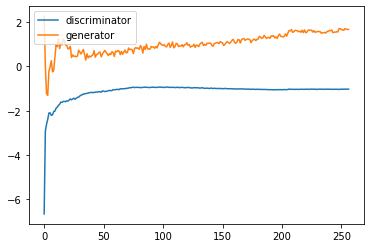

In [14]:
plt.plot(loss_d_arr,label='discriminator')
plt.legend(loc='upper left')
plt.plot(loss_g_arr,label='generator')
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Generated samples inception score: mean 3.0833895206451416 and std 0.0


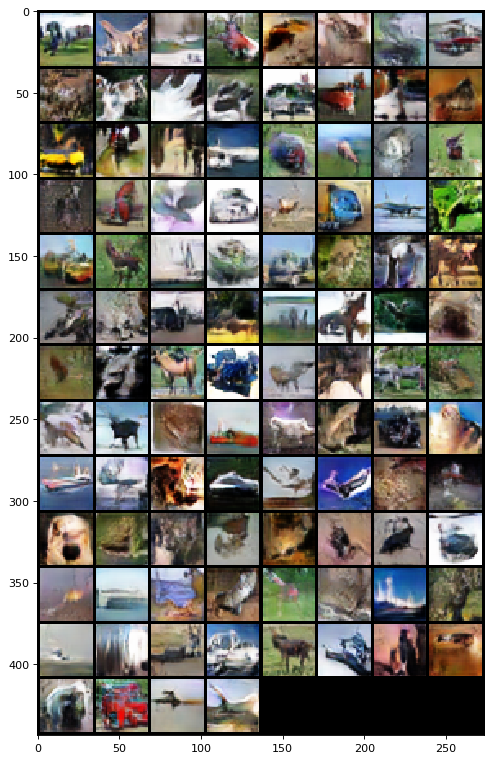

In [15]:
z_samples = torch.normal(mean=0, std=1.0, size = (100,128)).to(device)
samples = model_g.to(device)(z_samples.to(device))
inception_score = get_inception_score(inception_model.to(device),samples.detach(),split_size=100)
print("Generated samples inception score: mean {} and std {}".format(inception_score[0], inception_score[1]))
im = make_grid(samples,normalize=True)
fig=plt.figure(figsize=(14, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(np.transpose(im.cpu().detach().numpy(), (1,2,0)), interpolation='nearest')
plt.show()

#### Task 3
WGAN-GP, with self-modulated batch-normalization in the generator [ie, the gain and bias terms are a function of z at each ResBlockUp]. This is explained in [this](https://arxiv.org/pdf/1810.01365.pdf).

In [0]:
step_num = 50000
batch_size = 128
epoch_steps = len(cifar_train) // batch_size
epoch_num = (step_num) // epoch_steps
lam = 10
n_critic = 5
epoch_num

128

In [0]:
model_g = Generator(expan=2,modulate=True,condition_size = 128).to(device)
model_d = Discriminator().to(device)
optim_g = torch.optim.Adam(model_g.parameters(),lr=2e-4, betas=(0,0.9))
optim_d = torch.optim.Adam(model_d.parameters(),lr=2e-4, betas=(0,0.9))
scheduler_d = torch.optim.lr_scheduler.CosineAnnealingLR(optim_d, step_num)
scheduler_g = torch.optim.lr_scheduler.CosineAnnealingLR(optim_g, step_num)

train_loader = DataLoader(cifar_train, batch_size =batch_size,shuffle = True)
val_loader = DataLoader(cifar_val, batch_size =batch_size,shuffle = False)

In [0]:
# # restore model
# checkpoint = torch.load("/content/drive/My Drive/task_a_gan_discriminator_mod.tar",map_location=torch.device(device))
# model_d.load_state_dict(checkpoint["model"])
# optim_d.load_state_dict(checkpoint["optimizer"])
# loss_d_arr = checkpoint["loss"]
# checkpoint = torch.load("/content/drive/My Drive/task_a_gan_generator_mod.tar",map_location=torch.device(device))
# model_g.load_state_dict(checkpoint["model"])
# optim_g.load_state_dict(checkpoint["optimizer"])
# loss_g_arr = checkpoint["loss"]

In [0]:
loss_d_arr, loss_g_arr = [], []
for epoch in tqdm(range(0,epoch_num), total = epoch_num, desc="Epochs"):
  loss_d_epoch, loss_g_epoch = 0, 0
  for step, (x_real,_) in tqdm(enumerate(train_loader),total=len(train_loader), desc="Batches"):
    x_real = x_real.to(device)
    optim_d.zero_grad()
    z = torch.normal(mean=0, std=1.0, size = (x_real.size()[0],128)).to(device)
    eps = torch.rand(x_real.size()[0]).view(-1,1,1,1).to(device)
    x_fake = model_g(z).detach()
    x_fake.requires_grad_()
    x_real.requires_grad_()
    x_interpolate = (eps*x_real)+ ((1-eps)*x_fake)
    loss_d = model_d(x_fake).mean() - model_d(x_real).mean() + (lam * gp(x_interpolate, model_d))
    loss_d_epoch += loss_d.item()
    loss_d.backward()
    optim_d.step()

    if (step+1)%n_critic == 0:
      optim_g.zero_grad()
      z = torch.normal(mean=0, std=1.0, size = (x_real.size()[0],128)).to(device)
      loss_g = criterion_g(model_d(model_g(z)))
      loss_g_epoch += loss_g.item()
      loss_g.backward()
      optim_g.step()
    if step%100==0:
      tqdm.write("Step Disriminator loss {} \n\tGenerator loss {} ".format(loss_d, loss_g) )
    scheduler_g.step()
    scheduler_d.step()
  tqdm.write("Epoch {}\tDisriminator loss {} \n\tGenerator loss {} ".format(epoch,loss_d_epoch/step, loss_g_epoch/(step//5) ))
  loss_d_arr.append(loss_d_epoch/step)
  loss_g_arr.append(loss_g_epoch/step)
  # z = torch.normal(mean=0, std=1.0, size = (100,128)).to(device)
  # save_image(model_g(z),"/content/drive/My Drive/gifs_mod/epoch_{}.jpg".format(epoch),normalize = True)
  # model_save_name = 'task_a_gan_generator_mod.tar' 
  # path = F"/content/drive/My Drive/{model_save_name}"
  # state_dict = {"model": model_g.state_dict(), "optimizer": optim_g.state_dict(), "loss":loss_g_arr}
  # torch.save(state_dict, path)
  # print("generator saved successfuly") 
  # model_save_name = 'task_a_gan_discriminator_mod.tar' 
  # path = F"/content/drive/My Drive/{model_save_name}"
  # state_dict = {"model": model_d.state_dict(), "optimizer": optim_d.state_dict(),"loss":loss_d_arr}
  # torch.save(state_dict, path)
  # print("discriminator saved successfuly") 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Step Disriminator loss 6.403682708740234 
	Generator loss 0 


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Step Disriminator loss -18.554052352905273 
	Generator loss 15.65085220336914 
Step Disriminator loss -5.155337333679199 
	Generator loss 0.8264304399490356 
Step Disriminator loss -1.3153812885284424 
	Generator loss 3.9693186283111572 

Epoch 0	Disriminator loss -11.295875175946797 
	Generator loss 2.8382889800346813 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -6.983712196350098 
	Generator loss 12.32616901397705 
Step Disriminator loss -5.44055700302124 
	Generator loss 28.253177642822266 
Step Disriminator loss -6.020199775695801 
	Generator loss -14.502433776855469 
Step Disriminator loss -4.005967140197754 
	Generator loss 20.624923706054688 

Epoch 1	Disriminator loss -7.4474194416633015 
	Generator loss 17.426533044912876 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -5.580450057983398 
	Generator loss 33.51024627685547 
Step Disriminator loss -4.695958614349365 
	Generator loss 26.158008575439453 
Step Disriminator loss -3.0105772018432617 
	Generator loss 9.324535369873047 
Step Disriminator loss -1.9009803533554077 
	Generator loss 10.75020980834961 

Epoch 2	Disriminator loss -4.713992952994811 
	Generator loss 18.660796899061936 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -4.630112171173096 
	Generator loss 22.78578758239746 
Step Disriminator loss -0.21981018781661987 
	Generator loss 3.43430233001709 
Step Disriminator loss 7.711077690124512 
	Generator loss 48.69459533691406 
Step Disriminator loss -0.5950626730918884 
	Generator loss 22.53586196899414 

Epoch 3	Disriminator loss -3.1711836975354415 
	Generator loss 14.303330138707773 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.6243579387664795 
	Generator loss 26.893665313720703 
Step Disriminator loss -0.18794071674346924 
	Generator loss 3.713449239730835 
Step Disriminator loss 0.6929837465286255 
	Generator loss 14.988288879394531 
Step Disriminator loss 0.440621554851532 
	Generator loss 13.157114028930664 

Epoch 4	Disriminator loss -2.1702232853342327 
	Generator loss 10.957742825914652 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.9418824911117554 
	Generator loss 11.805126190185547 
Step Disriminator loss -1.201682686805725 
	Generator loss -1.0618833303451538 
Step Disriminator loss -1.8992146253585815 
	Generator loss 11.37042236328125 
Step Disriminator loss -0.9088954329490662 
	Generator loss 17.778583526611328 

Epoch 5	Disriminator loss -1.7698660454306847 
	Generator loss 9.467898763143099 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.9294339418411255 
	Generator loss 24.440814971923828 
Step Disriminator loss -0.31726694107055664 
	Generator loss 7.135398864746094 
Step Disriminator loss 2.3083128929138184 
	Generator loss -14.689882278442383 
Step Disriminator loss -0.021813184022903442 
	Generator loss 15.878860473632812 

Epoch 6	Disriminator loss -1.581963862402317 
	Generator loss 9.883961820831665 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.1790751218795776 
	Generator loss 11.568717002868652 
Step Disriminator loss -1.1732640266418457 
	Generator loss 19.02669906616211 
Step Disriminator loss -0.5035978555679321 
	Generator loss 5.550604820251465 
Step Disriminator loss -0.8894021511077881 
	Generator loss 7.618157386779785 

Epoch 7	Disriminator loss -1.5383842192399195 
	Generator loss 9.940441779219187 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.41809141635894775 
	Generator loss 13.656167030334473 
Step Disriminator loss -0.9237387776374817 
	Generator loss 20.685232162475586 
Step Disriminator loss 0.38254496455192566 
	Generator loss -6.9002685546875 
Step Disriminator loss -1.2901021242141724 
	Generator loss -1.8438148498535156 

Epoch 8	Disriminator loss -1.4924526245930256 
	Generator loss 9.015650578416311 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7574111819267273 
	Generator loss 4.6625518798828125 
Step Disriminator loss -1.6067970991134644 
	Generator loss 6.731405735015869 
Step Disriminator loss -0.8402687311172485 
	Generator loss 11.3164701461792 
Step Disriminator loss 1.8738269805908203 
	Generator loss -14.388021469116211 

Epoch 9	Disriminator loss -1.462461983775481 
	Generator loss 5.6429214876813765 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.4439185857772827 
	Generator loss -3.9504282474517822 
Step Disriminator loss -1.013885259628296 
	Generator loss 18.654815673828125 
Step Disriminator loss -0.9461128115653992 
	Generator loss 2.8523335456848145 
Step Disriminator loss -0.8073963522911072 
	Generator loss 5.273727893829346 

Epoch 10	Disriminator loss -1.3629700609697746 
	Generator loss 6.52050314251429 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.4233572483062744 
	Generator loss 4.569293022155762 
Step Disriminator loss -1.3667994737625122 
	Generator loss 10.415190696716309 
Step Disriminator loss -0.3097628653049469 
	Generator loss -2.3163347244262695 
Step Disriminator loss -0.21940621733665466 
	Generator loss 6.875119209289551 

Epoch 11	Disriminator loss -1.3035110916082675 
	Generator loss 5.864805865364197 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.160385012626648 
	Generator loss 4.679862976074219 
Step Disriminator loss -0.6008367538452148 
	Generator loss -6.24465274810791 
Step Disriminator loss -1.184136152267456 
	Generator loss 8.838096618652344 
Step Disriminator loss -0.36097392439842224 
	Generator loss 0.40177029371261597 

Epoch 12	Disriminator loss -1.245239168481949 
	Generator loss 7.059658083013999 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.6760550737380981 
	Generator loss 3.4365181922912598 
Step Disriminator loss -0.12978677451610565 
	Generator loss 0.8023508787155151 
Step Disriminator loss -0.8575089573860168 
	Generator loss 8.095813751220703 
Step Disriminator loss -0.7386890053749084 
	Generator loss 8.280275344848633 

Epoch 13	Disriminator loss -1.185143782141117 
	Generator loss 6.432189680635929 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -0.7986264824867249 
	Generator loss -0.21037085354328156 
Step Disriminator loss -0.7092093825340271 
	Generator loss 8.973491668701172 
Step Disriminator loss -0.7852519750595093 
	Generator loss 3.1100821495056152 
Step Disriminator loss 0.16182298958301544 
	Generator loss -8.722311973571777 

Epoch 14	Disriminator loss -1.1816050482866092 
	Generator loss 6.820595487761191 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.238176941871643 
	Generator loss 18.213661193847656 
Step Disriminator loss -1.0486581325531006 
	Generator loss 7.018510818481445 
Step Disriminator loss 0.6944175958633423 
	Generator loss 7.479769229888916 
Step Disriminator loss -0.40620189905166626 
	Generator loss 2.2092278003692627 

Epoch 15	Disriminator loss -1.1523460400028107 
	Generator loss 5.7798474570497484 
generator saved successfuly
discriminator saved successfuly


Step Disriminator loss -1.5141124725341797 
	Generator loss 12.7539701461792 
Step Disriminator loss 0.4600432813167572 
	Generator loss -8.836570739746094 
Step Disriminator loss 0.7413713932037354 
	Generator loss 3.7375900745391846 


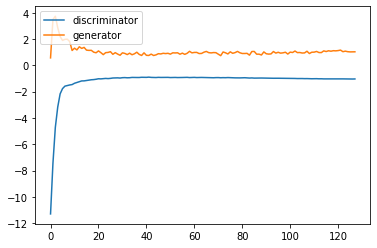

In [0]:
plt.plot(loss_d_arr,label='discriminator')
plt.legend(loc='upper left')
plt.plot(loss_g_arr,label='generator')
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Generated samples inception score: mean 3.753633975982666 and std 0.0


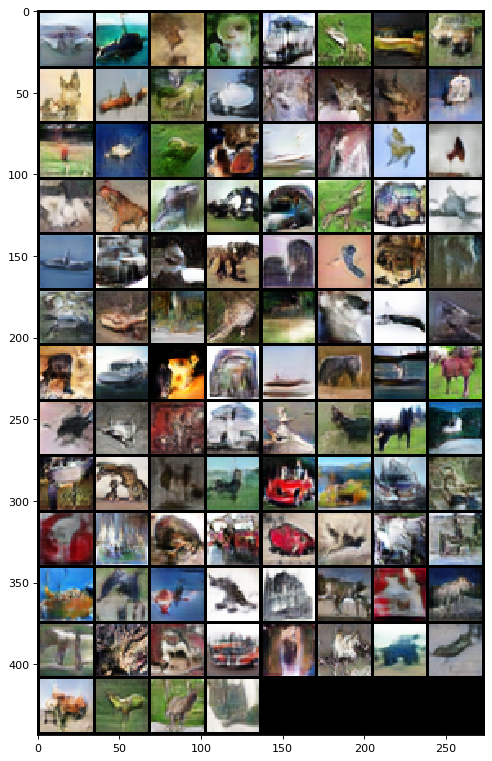

In [0]:
z_samples = torch.normal(mean=0, std=1.0, size = (100,128)).to(device)
samples = model_g.to(device)(z_samples.to(device))
inception_score = get_inception_score(inception_model.to(device),samples.detach(),split_size=100)
print("Generated samples inception score: mean {} and std {}".format(inception_score[0], inception_score[1]))
im = make_grid(samples,normalize=True)
fig=plt.figure(figsize=(14, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(np.transpose(im.cpu().detach().numpy(), (1,2,0)), interpolation='nearest')
plt.show()